# Weight tracking, analysis and forecast

## Setup

In [1]:
import numpy as np
import datetime
from datetime import date
import matplotlib.pyplot as plt

from sklearn.linear_model import LinearRegression
import os
import sys
import pandas as pd
import seaborn as sns
import tensorflow as tf

In [2]:
print(f'Python = {sys.version}')
print(f'Numpy = {np.__version__}')
print(f'Tensorflow = {tf.__version__}')

Python = 3.8.11 (default, Aug  6 2021, 09:57:55) [MSC v.1916 64 bit (AMD64)]
Numpy = 1.20.3
Tensorflow = 2.5.0


In [3]:
import weightlib as wl

# Data Extraction

Les "données brutes" sont récupérées de deux fichiers :

=> file "data_BEN.zip" contains the file "weight.csv" with all daily measurements of total mass, fat mass.

=> file "Suivi_Poids.csv" has manually-entered daily numbers for total mass and fat mass, plus nutrition data (lipid, carbs, proteines), and calories data (ingested, spent with cardio, spent with strength training)

In [4]:
ROOT = os.getcwd() + '/'
print(f'current working directory is {ROOT}')
print(f'contains :')
print(f'{os.listdir(ROOT)}')

current working directory is c:\Users\benjamin.deporte\Documents\095_Code_Python_Toy\Weight/
contains :
['.git', '.ipynb_checkpoints', 'data_BEN.zip', 'desktop.ini', 'figure.jpg', 'Glycogene_metabolisme_effort.pdf', 'model.png', 'pat.txt', 'polar-user-data-export.zip', 'README.md', 'Suivi_Poids.csv', 'test_methodes.xlsx', 'tmp', 'weight.ipynb', 'weightlib.py', 'weight_arima.ipynb', 'weight_rapport.ipynb', 'weight_recherche.ipynb', '__pycache__']


In [5]:
ds = wl.GetData(ROOT + 'data_BEN.zip', ROOT + 'Suivi_Poids.csv')

In [6]:
ds.extract()

Extraction fichier Zip Healthmate dans c:\Users\benjamin.deporte\Documents\095_Code_Python_Toy\Weight/tmp...
... Done


In [7]:
raw_df = ds.get_dataframe()

raw_df.set_index('date', inplace=True)

In [8]:
raw_df

,masse_totale,masse_grasse,calories_in,glucides,lipides,proteines,calories_exercice,calories_cardio,calories_strength,duree_exercice
date,,,,,,,,,,
2020-09-01,101.250000,33.020000,2015.0,262.0,48.0,120.0,281.0,281.0,0.0,28.0
2020-09-02,101.150000,31.945000,1942.0,162.0,94.0,100.0,419.0,419.0,0.0,41.0
2020-09-03,101.200000,30.930000,1938.0,227.0,72.0,93.0,403.0,403.0,0.0,40.0
2020-09-04,100.800000,29.460000,1851.0,274.0,43.0,91.0,439.0,439.0,0.0,43.0
2020-09-05,100.600000,31.450000,1774.0,214.0,54.0,90.0,563.0,563.0,0.0,47.0
...,...,...,...,...,...,...,...,...,...,...
2022-01-05,68.381818,8.620909,2152.0,196.0,57.0,202.0,656.0,0.0,656.0,78.0
2022-01-06,68.127273,8.583636,2000.0,201.0,30.0,213.0,537.0,0.0,537.0,85.0
2022-01-07,68.154167,8.582500,2179.0,266.0,58.0,151.0,680.0,0.0,680.0,87.0


### Dataframe with 'engineered' features

In [9]:
df = raw_df

In [10]:
BMR_to_RMR_multiplier = 1.10  # arbitrary coefficient to go from Base Metabolism Rate to Rest Metabolism Rate

In [11]:
# calcule colonnes masse sèche, body fat % age, base metabolism, rest metabolism

df.insert( loc=list(df.columns).index('masse_grasse')+1,
          column = 'masse_seche',
          value = df['masse_totale'] - df['masse_grasse']
)

df.insert( loc=list(df.columns).index('masse_seche')+1,
          column = 'body_fat_percentage',
          value = df['masse_grasse'] / df['masse_totale']
)

df.insert( loc=list(df.columns).index('body_fat_percentage')+1,
          column = 'base_metabolism_rate',
          value = df['masse_seche'].apply(wl.kma)  # on utilise Katch Mac Ardle pour métabolisme de base : 370 + 21.6 * masse_seche
)

df.insert( loc=list(df.columns).index('base_metabolism_rate')+1,
          column = 'rest_metabolism_rate',
          value = df['base_metabolism_rate'] * BMR_to_RMR_multiplier
)


### Travail sur les calories d'exercice :
- prise en compte des variations de VO² max
- passage des calories brutes aux calories nettes

In [12]:
df.insert( loc = list(df.columns).index('calories_strength')+1,
          column = 'VO2_max',
          value = 0.0
          )

### Prise en compte du changement de VO² max !

Première période : recalcul des calories d'exercice, antérieurement à la date du 29/12/2021 :
- 27/3/2021, 4/5/2021 : VO² max = 39 ml/kg/min => TRES BAS !! ON PRENDRA V² max = 55.0 au 1er MARS 2021
- 29,30,31/12/2021 : VO² max = 64,67,67 ml/kg/min

Hypothèses de calcul : 
- constant à 55 ml/kg/min jusqu'au 1/3/2021
- constant à 67 ml/kg/min depuis le 29/12/2021
- linéaire entre les deux dates
- les calories d'exercice sont recalculées suivant : Male: ((-95.7735 + (0.634 x HR) + (0.404 x VO2max) + (0.394 x W) + (0.271 x A))/4.184) x 60 x T
- soit : new_cals = old_cals x VO²_new / VO²_old
- 
- (ref = http://www.shapesense.com/fitness-exercise/calculators/heart-rate-based-calorie-burn-calculator.shtml)

Au delà du 29/12/2021, on note dans le fichier les valeurs actualisées du VO² max pour référence, mais sans recalcul :
- 8/1/2022 : VO² max = 70 ml/kg/min

In [13]:
# recalcul, antérieurement au 29/12/2021

start_date = datetime.date(2021,3,1)
start_VO2 = 55.0  # GROSSE HYPOTHESE : VO² max = 55 ml/kg/min au 1er mars 2021...

end_date = datetime.date(2021,12,29)
end_VO2 = 66.0

In [14]:
df.loc[df.index <= start_date, 'VO2_max'] = start_VO2

dates = [ start_date + datetime.timedelta(i) for i in range(0, end_date.toordinal() - start_date.toordinal())]

pente = (end_VO2 - start_VO2) / (end_date.toordinal() - start_date.toordinal())

for d in dates:
    df.loc[d, 'VO2_max'] = start_VO2 + pente * (d.toordinal() - start_date.toordinal())

In [15]:
# dictionnaire des valeurs de VO² max, pour inscription pour informarion dans la dataframe
# valeurs postérieures au 29/12/2021

dict_VO2 = {
    datetime.date(2020,8,1) : 55.0,
    datetime.date(2021,12,29) : 67.0,
    datetime.date(2022,1,8) : 70.0,
}

dict_VO2 = dict(sorted(dict_VO2.items())) # trie si besoin

In [16]:
def get_VO2(d, dict_VO2 = dict_VO2):
    """Utility function. Gets value of VO2 at date d, in dictionnary dict_VO2

    Args:
        d (datetime.date): date à laquelle on cherche la valeur du VO2 max
        dict_VO2 (dictiionnary, optional): [description]. Defaults to dict_VO2.
        
    Retourne la valeur v_i correspondant à la clef date k_i dans dict_VO2, telle que k_i <= d < k_i+1,
    sinon la dernière valeur correspondant à k_last
    """
    
    k_last = list(dict_VO2.keys())[-1] # last date in dictionnary
    
    if d >= k_last:
        v_last = dict_VO2.get(k_last) # last value in dictionnary
        return v_last
    else:
        value = 55.0 # defaulty value before 1st August 2020
        for k,v in dict_VO2.items():
            if k <= d:
                value = v
        return value

In [17]:
for d in df.index:
    if d >= end_date:
        df.loc[d, 'VO2_max'] = get_VO2(d)

### Maintenant, on recalcule les calories d'exercice antérieurement au 29/12, en prenant en compte les valeurs calculées de VO² max, 

Puis calculer les valeurs nettes (hors RMR) après avoir importé les durées d'exercice

In [18]:
raw = [ 'calories_exercice',
       'calories_cardio',
       'calories_strength'
       ]

revised = ['calories_exercice_net',
       'calories_cardio_net',
       'calories_strength_net'
       ]

for r1, r2 in zip(raw, revised):
       delta_net_cals = df[[r1,'rest_metabolism_rate', 'duree_exercice']].apply( lambda x : (x[r1] > 0.0) * x['duree_exercice'] / 60 * x['rest_metabolism_rate'] / 24 , axis=1 )
       df.loc[ df.index < end_date, r2 ] = df[[r1,'VO2_max']].apply( lambda x : x[r1] * x['VO2_max'] / start_VO2, axis=1 )
       df.loc[ df.index >= end_date, r2] = df.loc[ df.index >= end_date, r1 ]
       df[r2] = df[r2] - delta_net_cals

In [19]:
df.insert( loc=list(df.columns).index('calories_strength_net')+1,
          column = 'calories_deficit',
          value = df['calories_in'] - df['rest_metabolism_rate'] - df['calories_exercice_net']
)

In [20]:
df

,masse_totale,masse_grasse,masse_seche,body_fat_percentage,base_metabolism_rate,rest_metabolism_rate,calories_in,glucides,lipides,proteines,calories_exercice,calories_cardio,calories_strength,VO2_max,duree_exercice,calories_exercice_net,calories_cardio_net,calories_strength_net,calories_deficit
date,,,,,,,,,,,,,,,,,,,
2020-09-01,101.250000,33.020000,68.230000,0.326123,1843.768000,2028.144800,2015.0,262.0,48.0,120.0,281.0,281.0,0.0,55.0,28.0,241.563851,241.563851,0.000000,-254.708651
2020-09-02,101.150000,31.945000,69.205000,0.315818,1864.828000,2051.310800,1942.0,162.0,94.0,100.0,419.0,419.0,0.0,55.0,41.0,360.594623,360.594623,0.000000,-469.905423
2020-09-03,101.200000,30.930000,70.270000,0.305632,1887.832000,2076.615200,1938.0,227.0,72.0,93.0,403.0,403.0,0.0,55.0,40.0,345.316244,345.316244,0.000000,-483.931444
2020-09-04,100.800000,29.460000,71.340000,0.292262,1910.944000,2102.038400,1851.0,274.0,43.0,91.0,439.0,439.0,0.0,55.0,43.0,376.230798,376.230798,0.000000,-627.269198
2020-09-05,100.600000,31.450000,69.150000,0.312624,1863.640000,2050.004000,1774.0,214.0,54.0,90.0,563.0,563.0,0.0,55.0,47.0,496.090147,496.090147,0.000000,-772.094147
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-01-05,68.381818,8.620909,59.760909,0.126070,1660.835636,1826.919200,2152.0,196.0,57.0,202.0,656.0,0.0,656.0,67.0,78.0,557.041877,0.000000,557.041877,-231.961077
2022-01-06,68.127273,8.583636,59.543636,0.125994,1656.142545,1821.756800,2000.0,201.0,30.0,213.0,537.0,0.0,537.0,67.0,85.0,429.465744,0.000000,429.465744,-251.222544
2022-01-07,68.154167,8.582500,59.571667,0.125928,1656.748000,1822.422800,2179.0,266.0,58.0,151.0,680.0,0.0,680.0,67.0,87.0,569.895289,0.000000,569.895289,-213.318089


### Quelques graphes

# Depuis le début

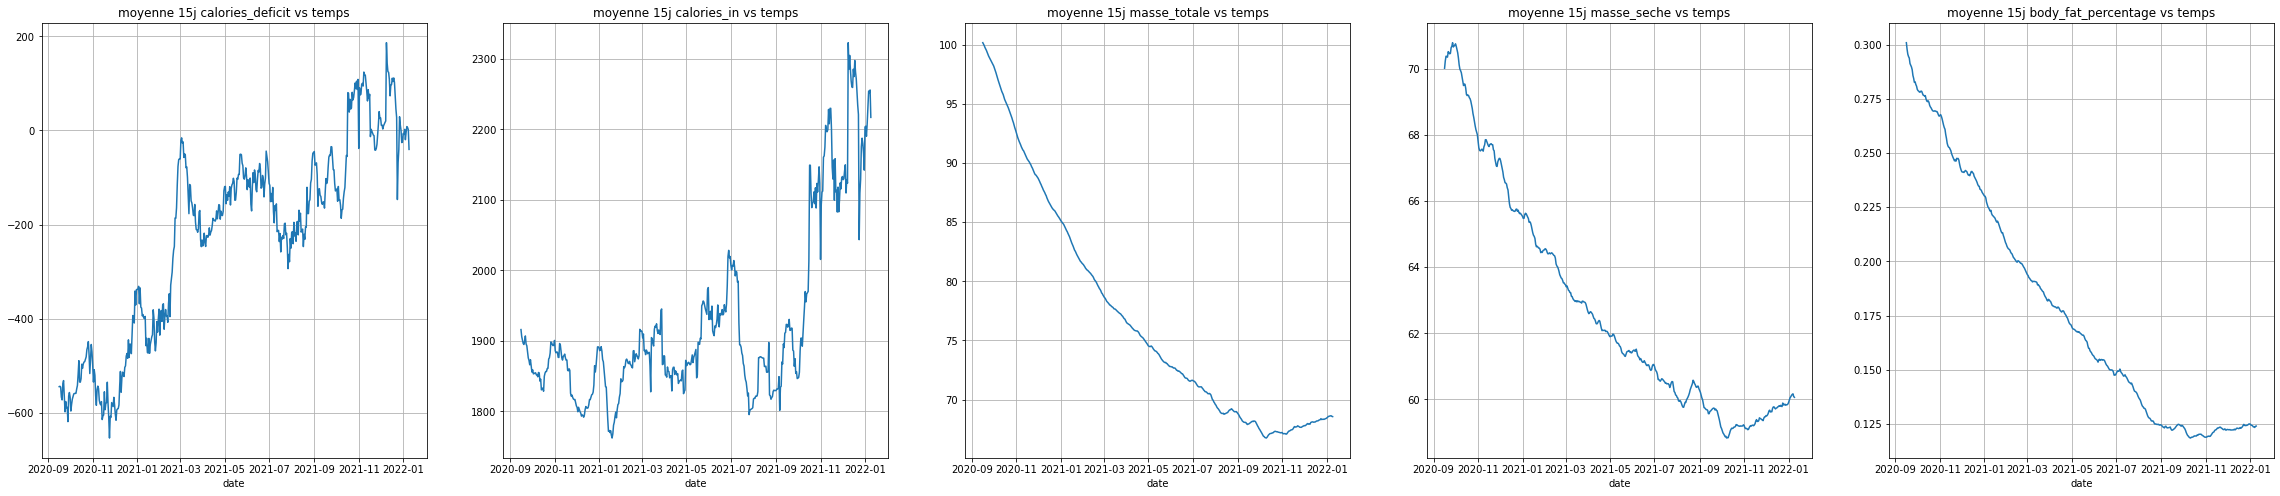

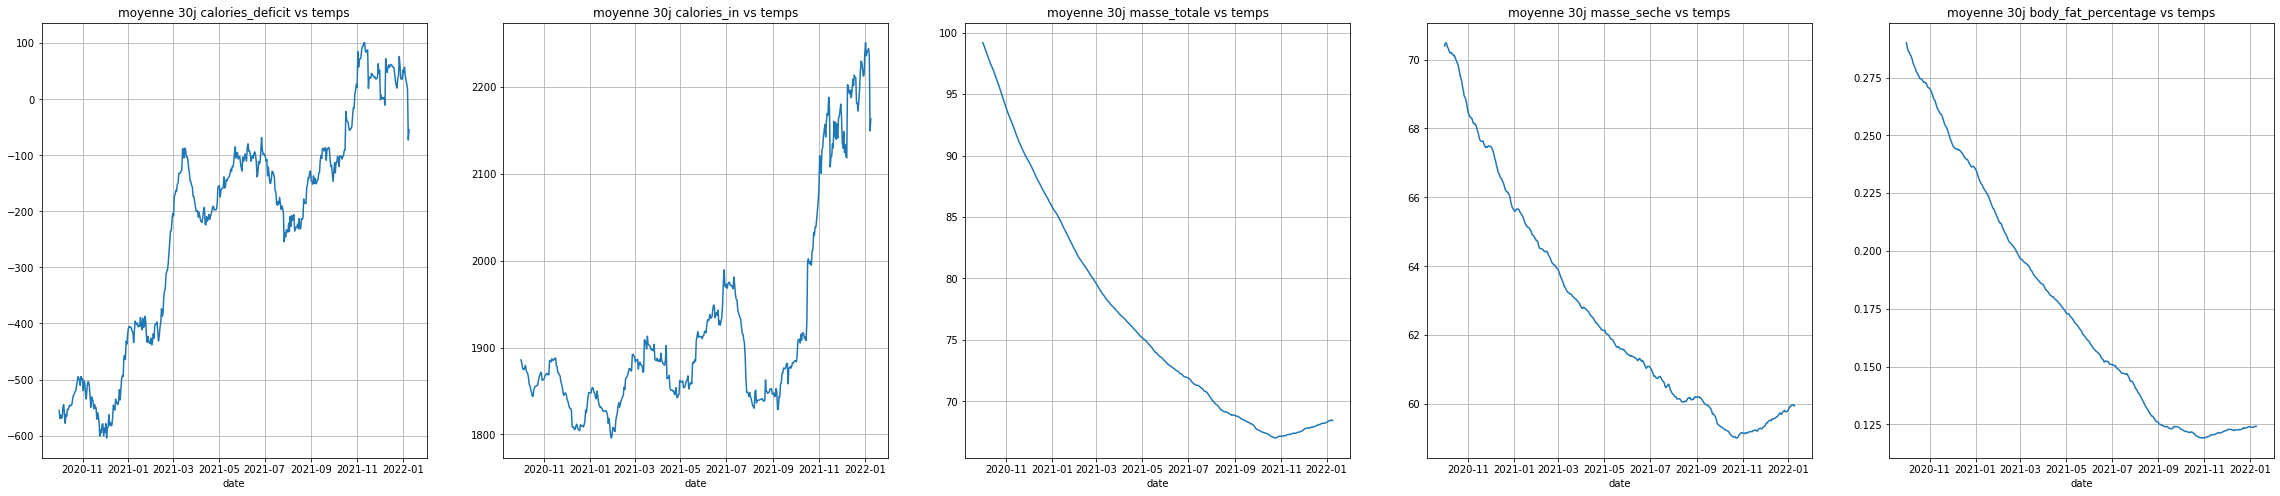

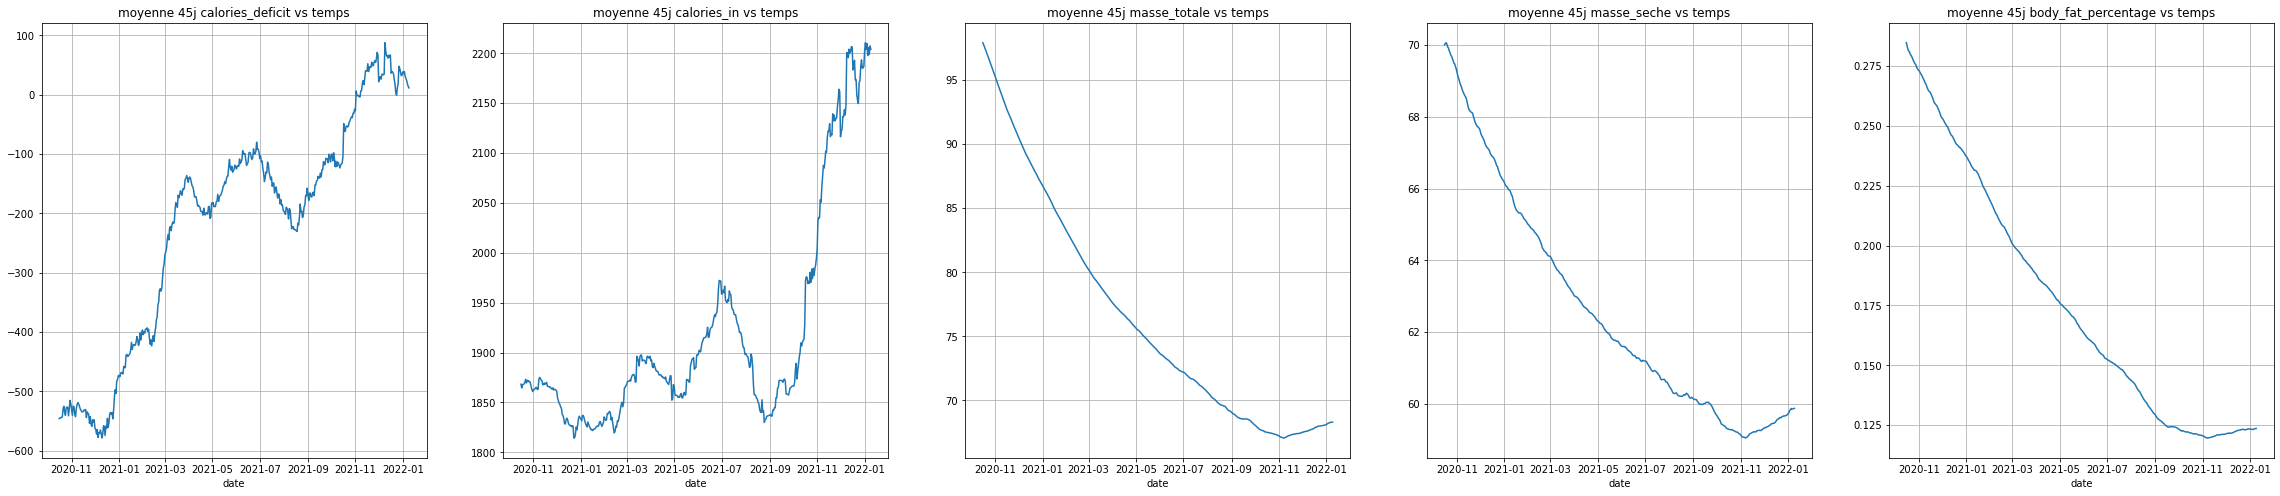

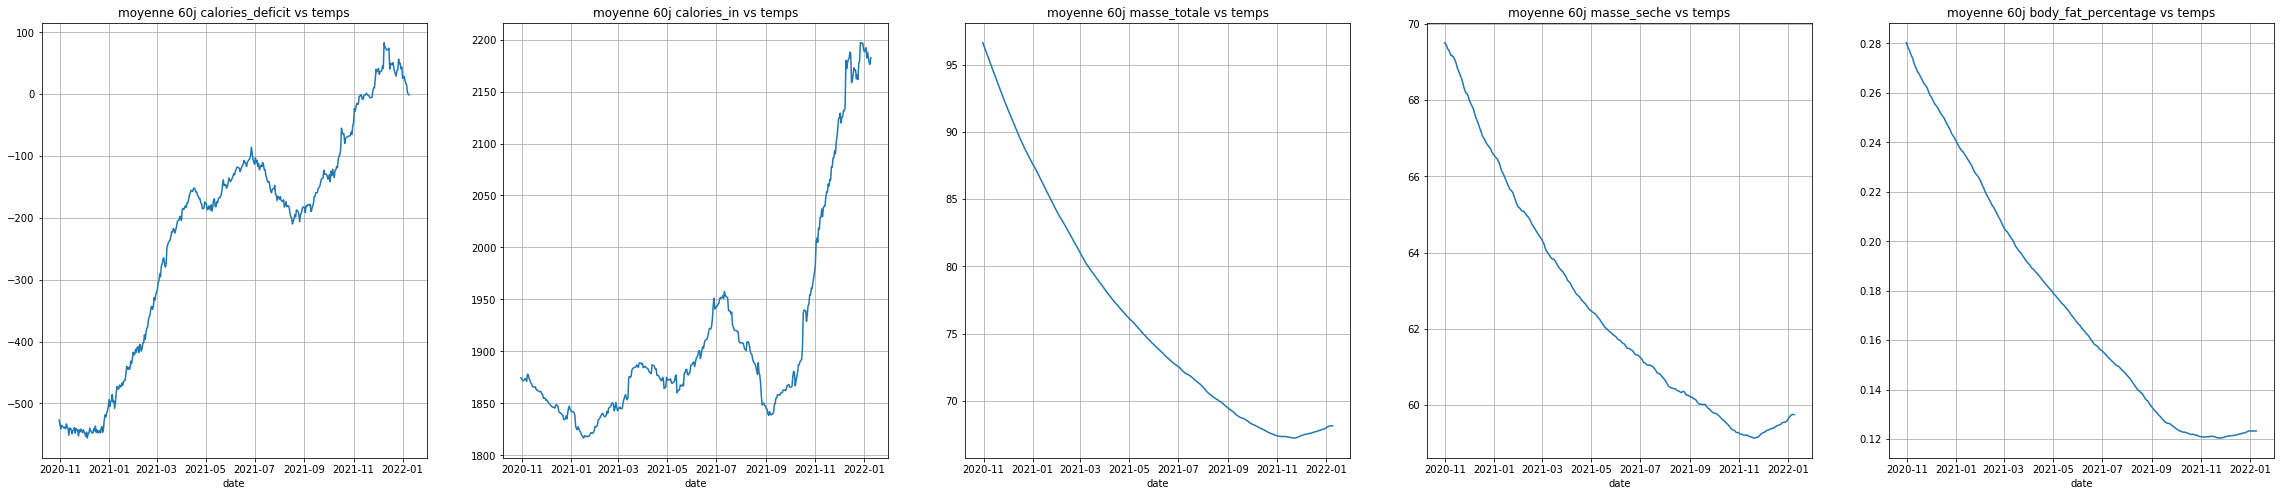

In [21]:
window_list = [15,30,45,60]

for w in window_list:
    wl.plot_moyennes(df, list_of_moyennes=['calories_deficit', 'calories_in', 'masse_totale', 'masse_seche', 'body_fat_percentage'], window=w)

# Depuis les 90 derniers jours

C:\Users\benjamin.deporte\Anaconda3\envs\toy\lib\site-packages\pandas\core\indexes\base.py:4616: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  result = getitem(key)


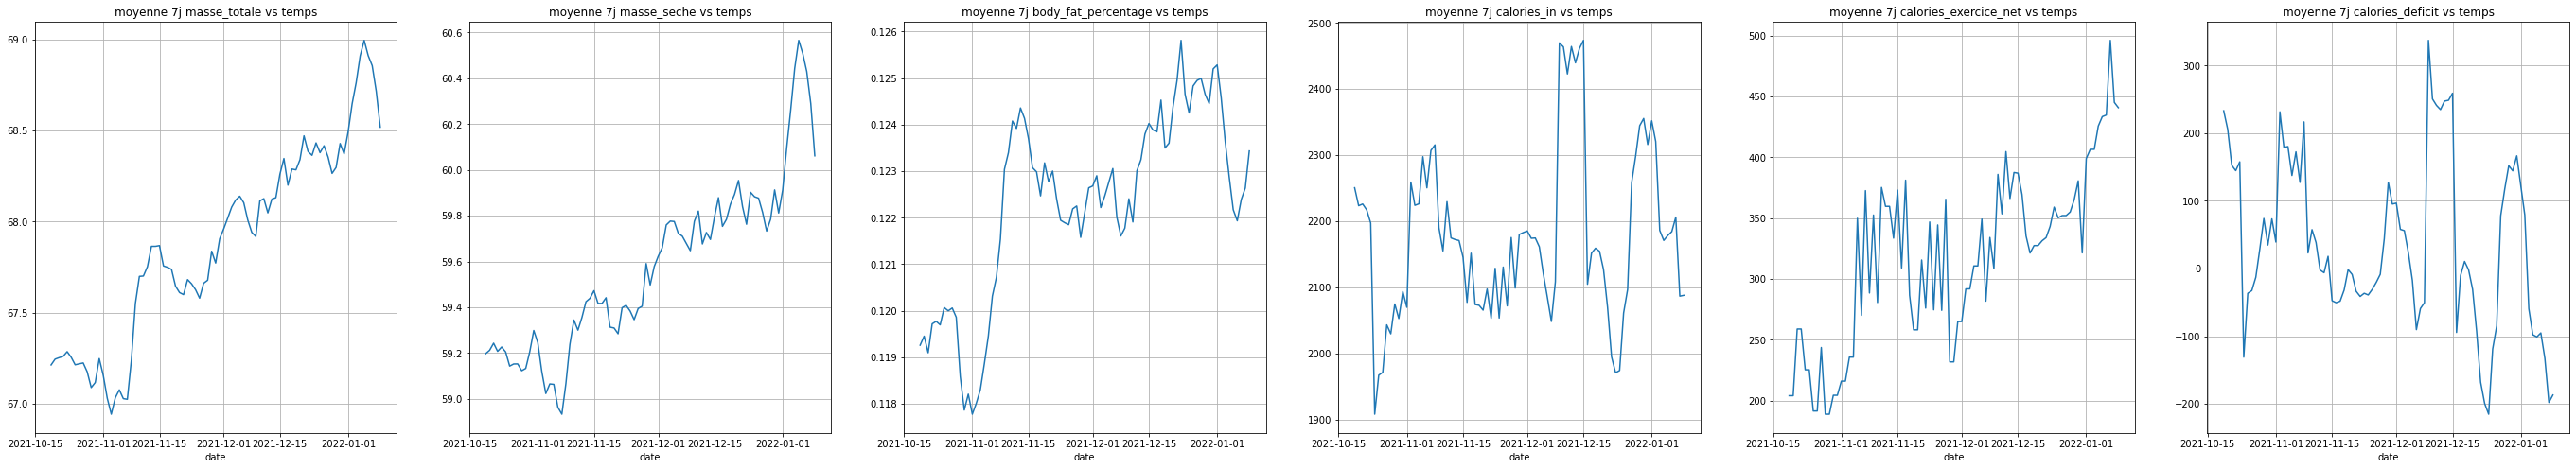

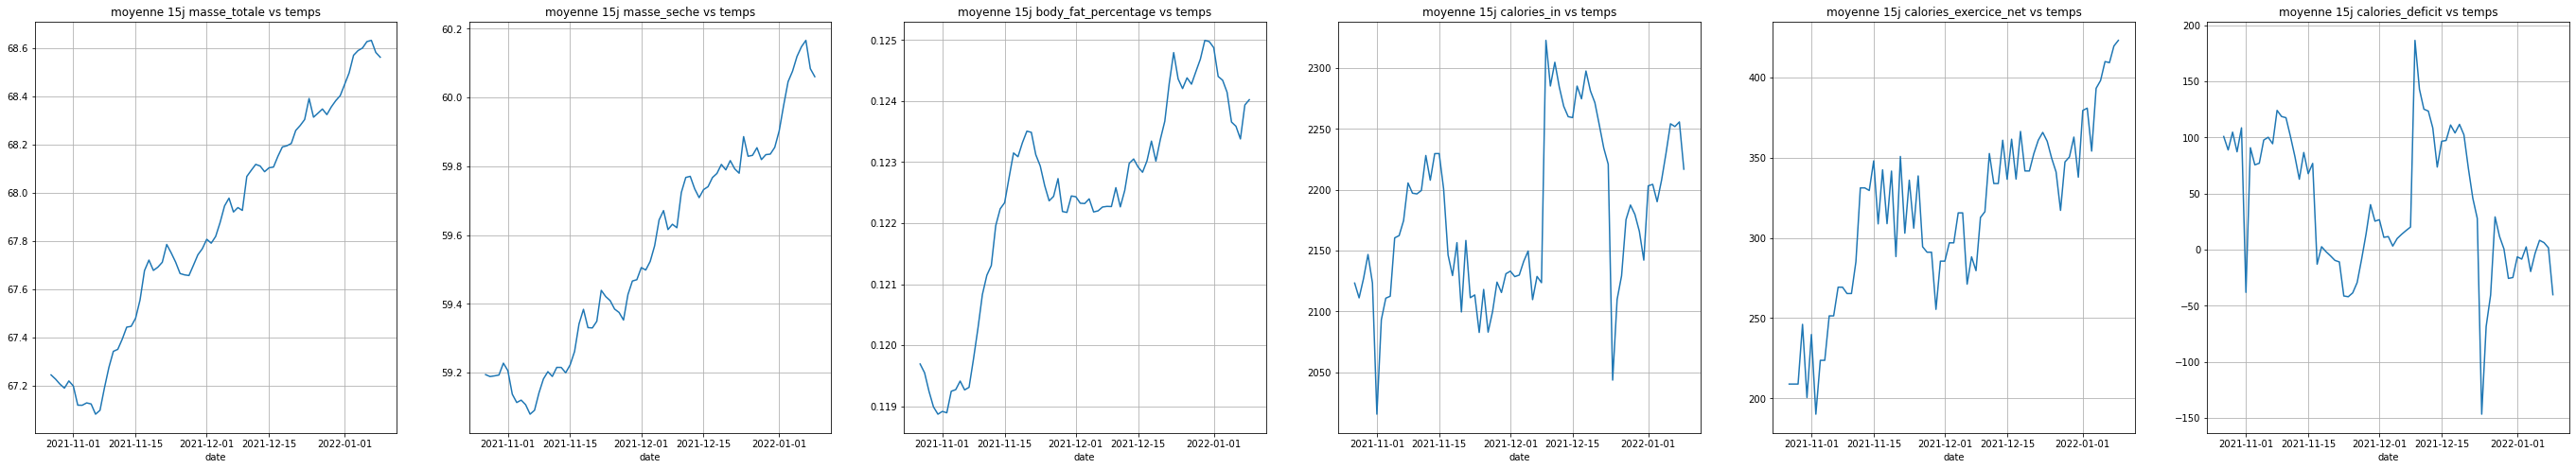

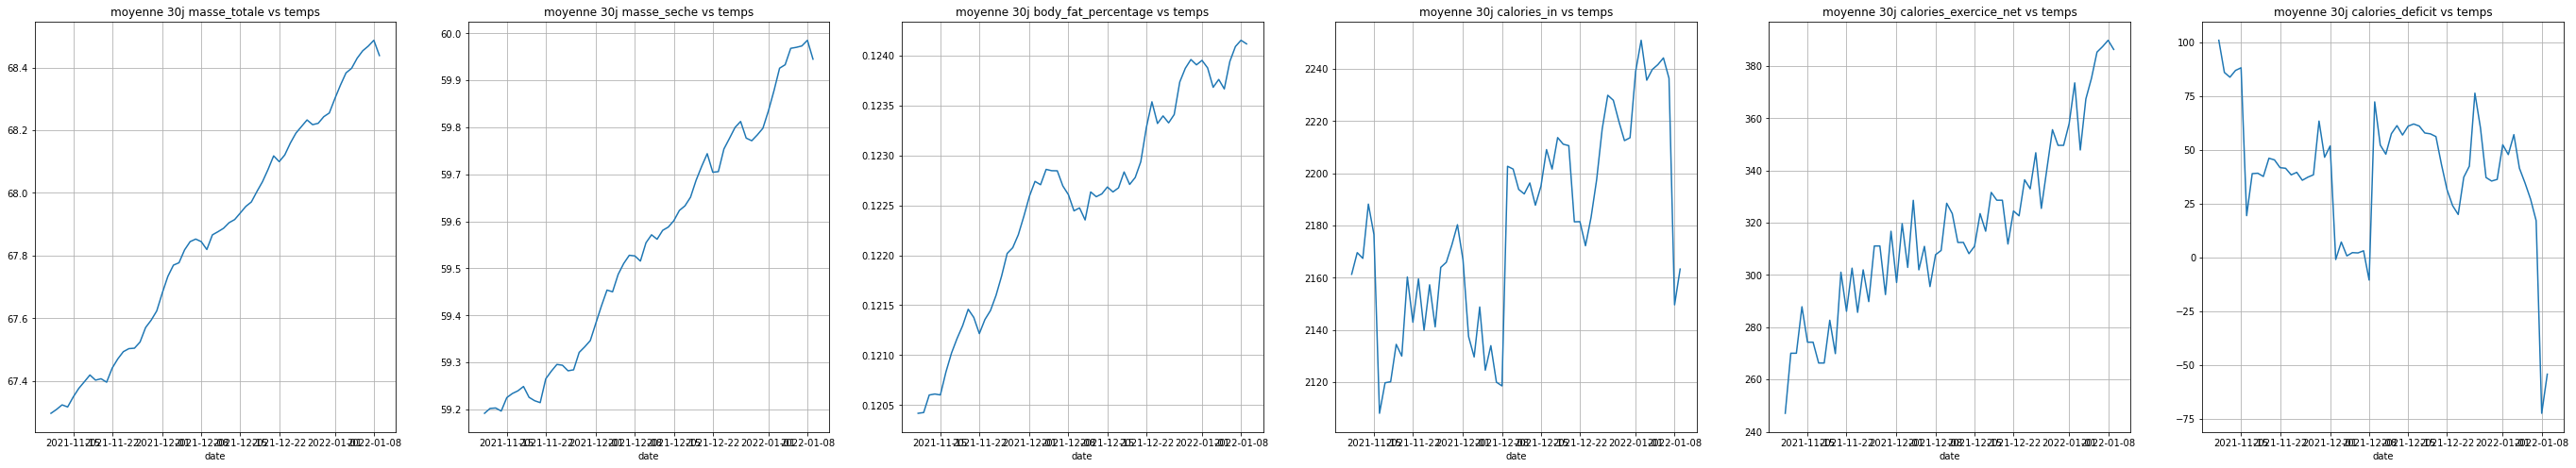

In [22]:
over_last_days = 90

start_date = datetime.date.today() - datetime.timedelta(days = over_last_days)
index_to_drop = [df.index < start_date]

df_last = df.drop(index = df.index[index_to_drop])

window_list = [7,15,30]

for w in window_list:
    wl.plot_moyennes(df=df_last, list_of_moyennes=['masse_totale', 'masse_seche', 'body_fat_percentage', 'calories_in', 'calories_exercice_net', 'calories_deficit'], window=w)

# On distingue deux périodes :
- une période de "sèche" jusqu'à fin septembre 2021 environ
- une période de "bulk" plus ou moins clean (?) à partir d'octobre 2021

In [23]:
cut_off = datetime.date(2021,10,1)

df_seche = df[df.index < cut_off]

df_bulk = df[df.index >= cut_off]


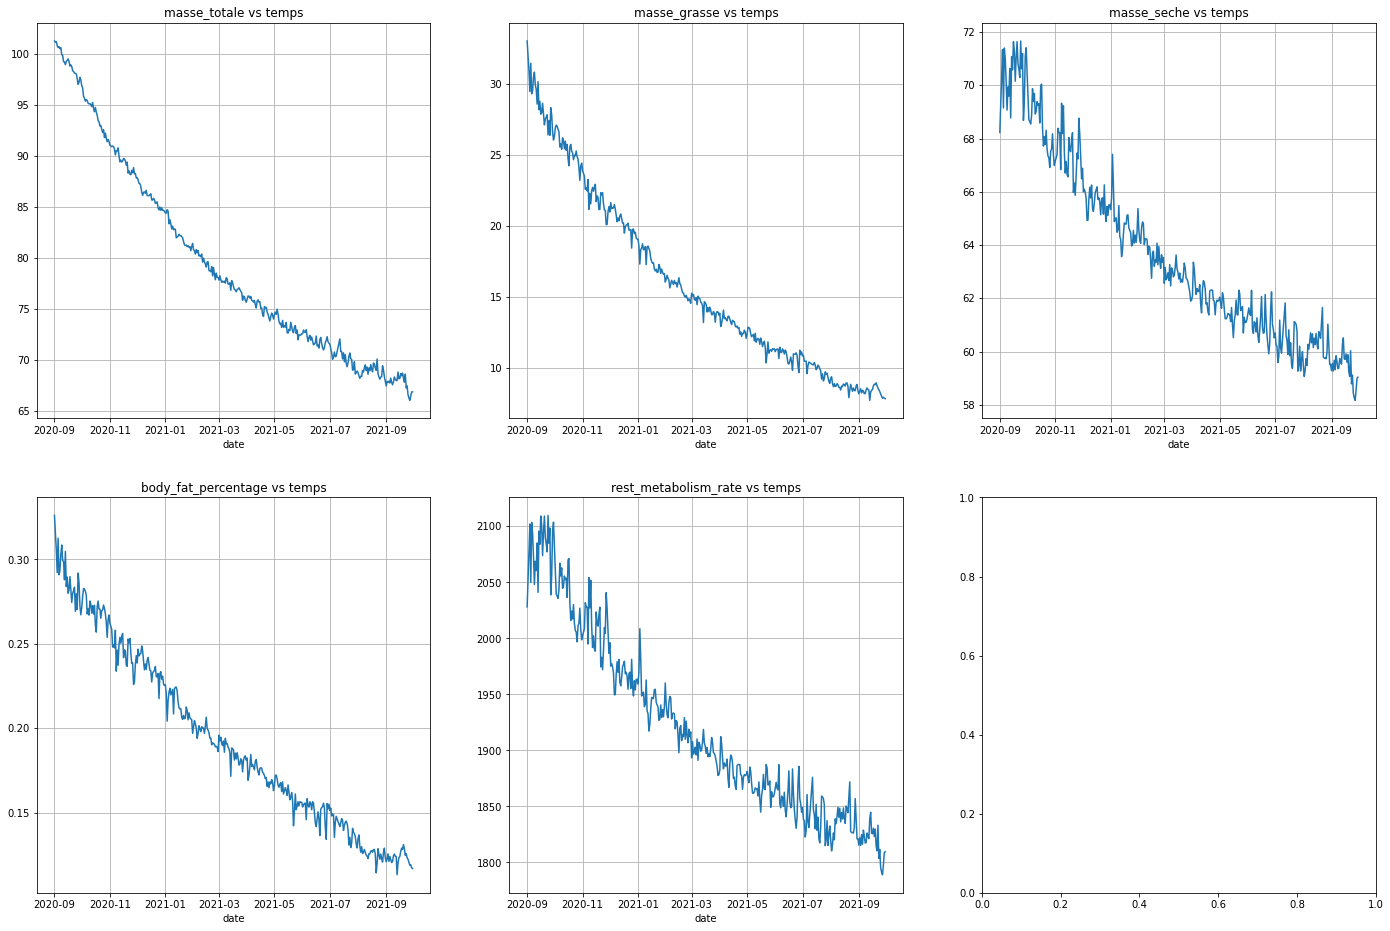

In [24]:
wl.plot_columns(df=df_seche,
                columns_list=['masse_totale', 'masse_grasse', 'masse_seche', 'body_fat_percentage', 'rest_metabolism_rate']
)

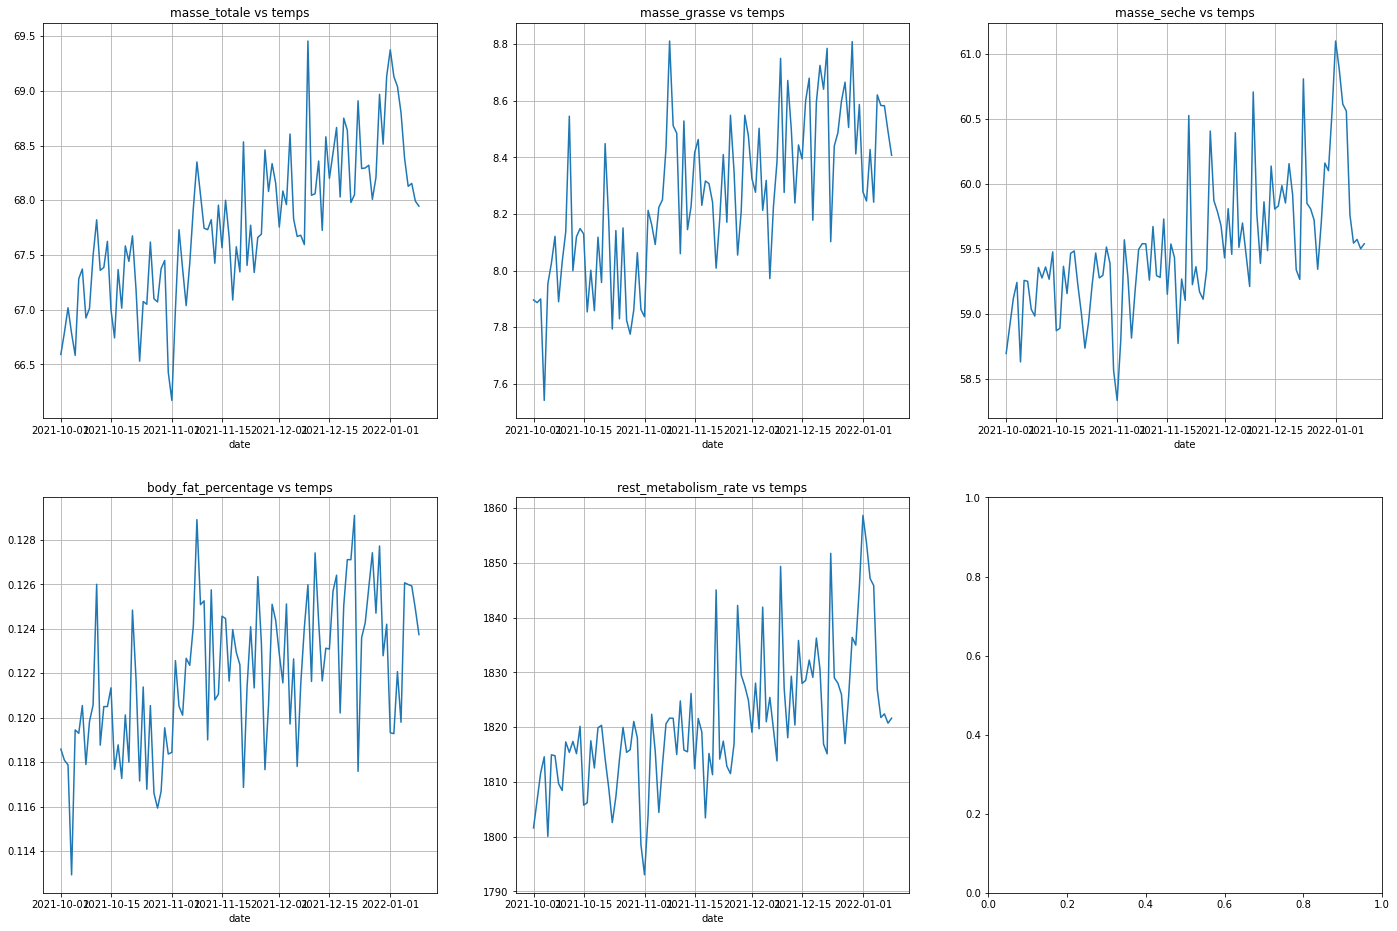

In [25]:
wl.plot_columns(df=df_bulk,
                columns_list=['masse_totale', 'masse_grasse', 'masse_seche', 'body_fat_percentage', 'rest_metabolism_rate']
)

# Quelles dynamiques sur les deux périodes ?

rythme mensuel moyen sur la période de masse_totale = -2.476 avec coeff correlation = 95.0%
rythme mensuel moyen sur la période de masse_seche = -0.861 avec coeff correlation = 92.0%
rythme mensuel moyen sur la période de body_fat_percentage = -0.014 avec coeff correlation = 97.0%


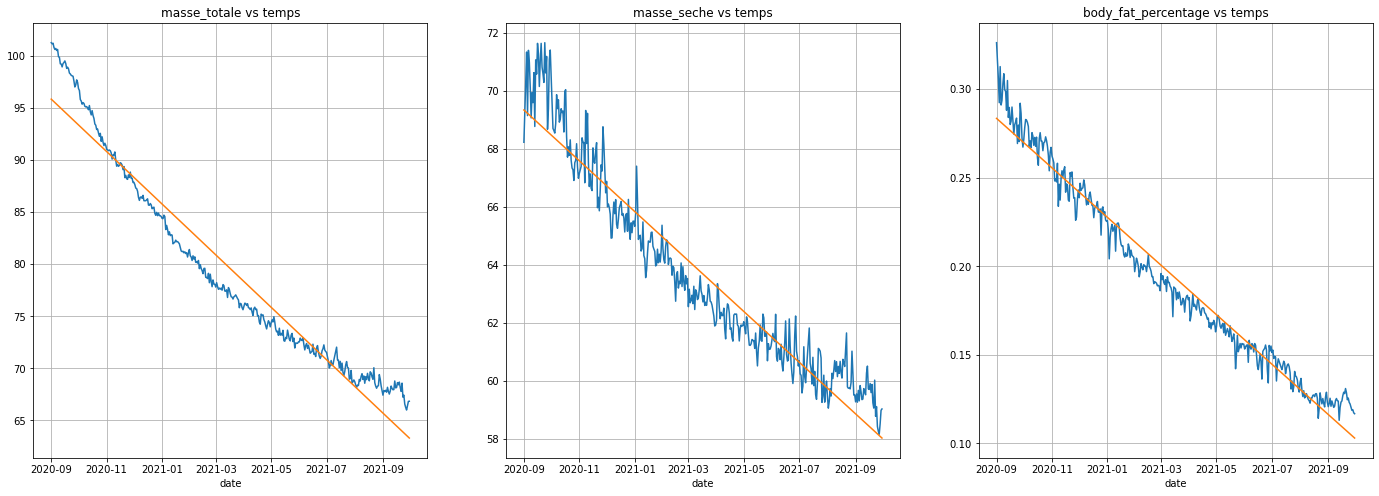

In [26]:
wl.plot_trends(df_seche)

rythme mensuel moyen sur la période de masse_totale = 0.537 avec coeff correlation = 61.0%
rythme mensuel moyen sur la période de masse_seche = 0.346 avec coeff correlation = 42.0%
rythme mensuel moyen sur la période de body_fat_percentage = 0.002 avec coeff correlation = 30.0%


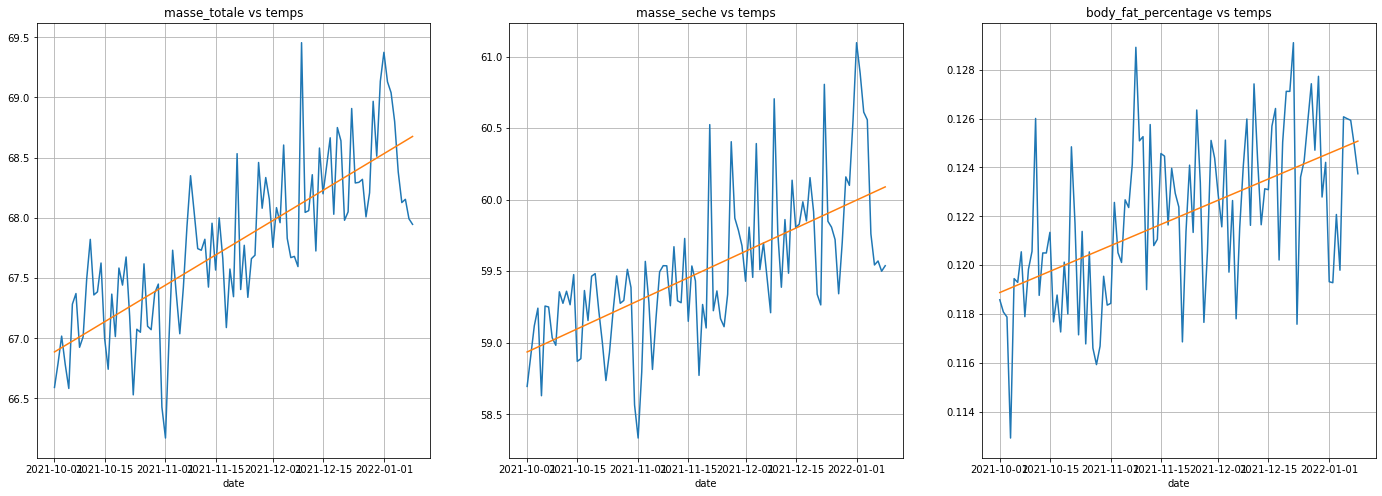

In [27]:
wl.plot_trends(df_bulk)

# Quelle(s) différence(s) principale(s) entre ces deux périodes ??

valeur médiane de calories_in pendant la période seche = 1831.0 kcals
valeur médiane de calories_in pendant la période bulk = 2111.0 kcals
---------------
valeur médiane de rest_metabolism_rate pendant la période seche = 1899.0 kcals
valeur médiane de rest_metabolism_rate pendant la période bulk = 1820.0 kcals
---------------
valeur médiane de calories_exercice_net pendant la période seche = 181.0 kcals
valeur médiane de calories_exercice_net pendant la période bulk = 380.0 kcals
---------------
valeur médiane de calories_deficit pendant la période seche = -221.0 kcals
valeur médiane de calories_deficit pendant la période bulk = -16.0 kcals
---------------


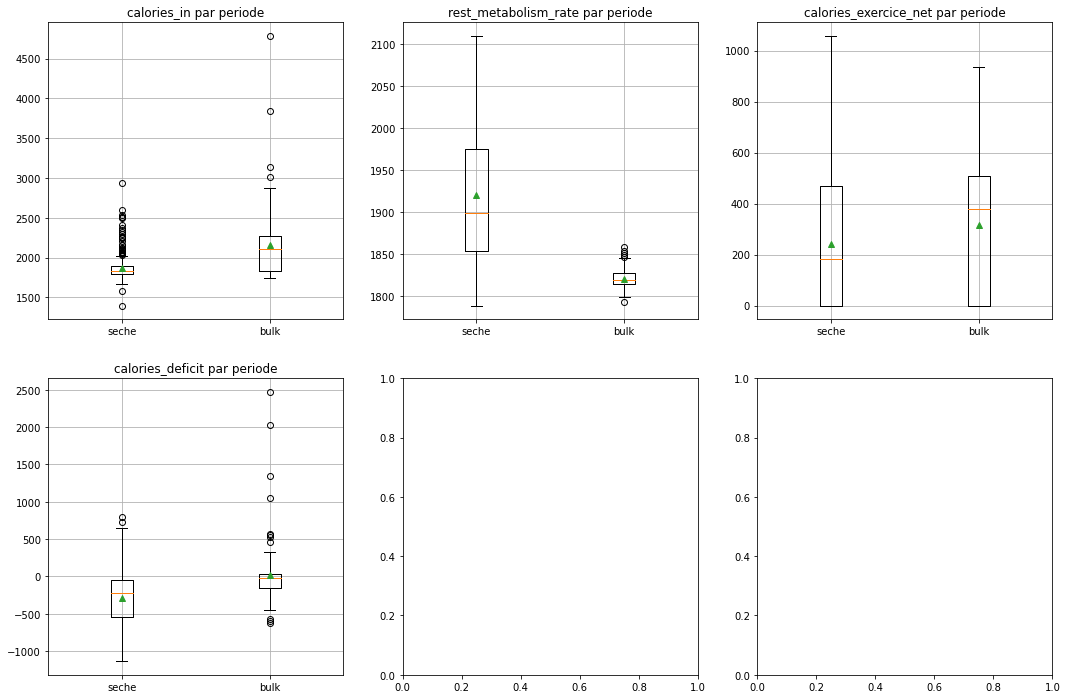

In [28]:
wl.plot_boxes(df_seche, df_bulk, columns_list=['calories_in', 'rest_metabolism_rate', 'calories_exercice_net', 'calories_deficit'])

### En regardant les médianes seules des deux périodes (certes de longueur différente)
le déficit calorique se rapproche de 0 pour le bulk

# Quelques corrélations

In [29]:
def get_periode(df):
    
    debut = df.index[0]
    fin = df.index[-1]
    periode_str = debut.strftime('%d/%m/%Y') + ' - ' + fin.strftime('%d/%m/%Y')
    return periode_str
    

In [30]:
def correlations_moyenne(df,
                         window=15, 
                         columns_y = ['masse_totale', 'masse_grasse', 'masse_seche'], 
                         y_list = ['variation_masse_totale_moyenne', 'variation_masse_grasse_moyenne', 'variation_masse_seche_moyenne'],
                         columns_x = ['calories_deficit', 'calories_cardio_net', 'calories_strength_net'],
                         x_list = ['calories_deficit_moyenne', 'calories_cardio_net_moyenne', 'calories_strength_net_moyenne']# , 'calories_cardio_moyenne', 'calories_strength_moyenne']
                         ):
    
    columns_y_variation_moyenne = [ 'variation_' + c + '_moyenne' for c in columns_y]
    columns_x_moyenne = [ c + '_moyenne' for c in columns_x]
    columns_all = columns_x + columns_y
    
    df_test = df[columns_all]
    
    name = get_periode(df)
    
    for c1, c2 in zip(columns_y, columns_y_variation_moyenne):
        df_test.loc[:,c2] = df_test[c1].diff(1).rolling(window).mean().to_numpy()
        
    for c1, c2 in zip(columns_x, columns_x_moyenne):
        df_test.loc[:,c2] = df_test[c1].rolling(window).mean().shift(1).to_numpy()
        
    df_test = df_test[window:]
    
    df_test.drop(columns = columns_x + columns_y, inplace=True)
    
    display(df_test.corr())
    
    nx = len(x_list)
    ny = len(y_list)
    unit_size = 6
    
    fig,ax = plt.subplots(ny, nx, figsize=(nx*unit_size, ny*unit_size))
    
    fig.suptitle('Periode : ' + name + f'\nValeurs quotidiennes moyennes sur une fenêtre de {window} jours')

    for r,y in enumerate(y_list):
        for c,x in enumerate(x_list):
            ax[r,c] = df_test.plot.scatter(x,y, ax = ax[r,c], grid=True)

    plt.savefig('figure.jpg', format='jpg')
    plt.show()
    

C:\Users\benjamin.deporte\Anaconda3\envs\toy\lib\site-packages\pandas\core\indexing.py:1667: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value


,variation_masse_totale_moyenne,variation_masse_grasse_moyenne,variation_masse_seche_moyenne,calories_deficit_moyenne,calories_cardio_net_moyenne,calories_strength_net_moyenne
variation_masse_totale_moyenne,1.000000,0.937878,0.843615,0.945306,-0.896114,0.884628
variation_masse_grasse_moyenne,0.937878,1.000000,0.604905,0.923265,-0.888235,0.835621
variation_masse_seche_moyenne,0.843615,0.604905,1.000000,0.740703,-0.682017,0.737080
calories_deficit_moyenne,0.945306,0.923265,0.740703,1.000000,-0.953476,0.794993
calories_cardio_net_moyenne,-0.896114,-0.888235,-0.682017,-0.953476,1.000000,-0.743553
calories_strength_net_moyenne,0.884628,0.835621,0.737080,0.794993,-0.743553,1.000000


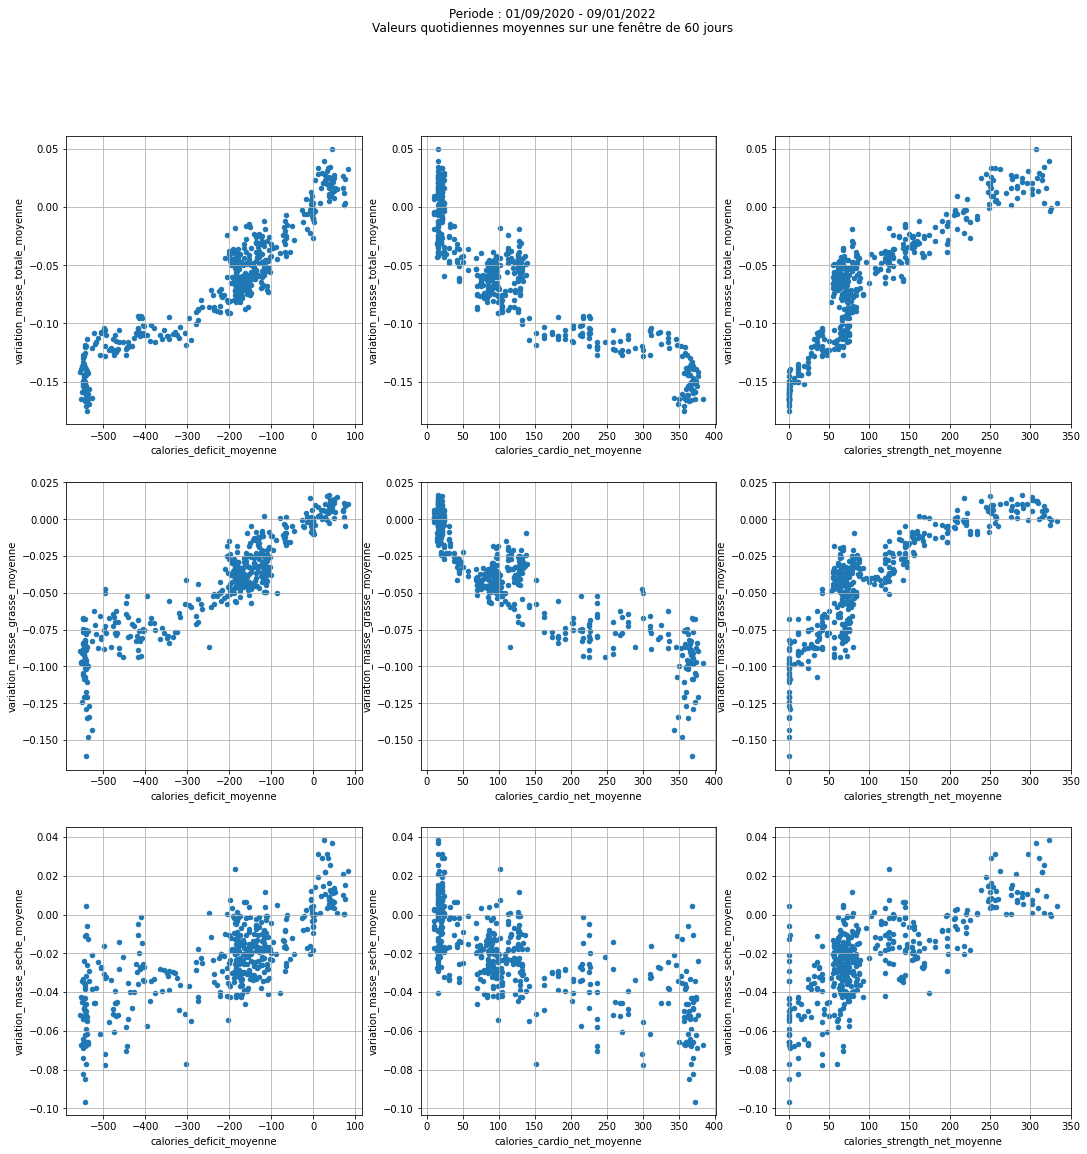

In [31]:
correlations_moyenne(df, window=60)

## Nouvelle politique :
- target déficit calorique quotidien : **-150 kcals** (rythme estimé : -750g graisse/mois, soit -1% body fat %age)
- target calories strength : 350 kcals net quotidien (soit, à 6 sessions/semaine : 410 kcals net/session, à 1h20 RMR 1830 kcals : **515 kcals brut / session, x 6 sessions/semaine** ) => target 450 kcals bruts quotidiens session 1h20
- (NB : deficit calorique = calories in - ( KMA + 10% + exercice net ) )
- target MyFitnessPas : RMR 1850 + exercice net 350 - deficit 150 = 2050 ... on commence à **1850 kcals**

## Depuis mise à jour du VO² max au 29/12/2021

C:\Users\benjamin.deporte\Anaconda3\envs\toy\lib\site-packages\pandas\core\indexes\base.py:4616: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  result = getitem(key)


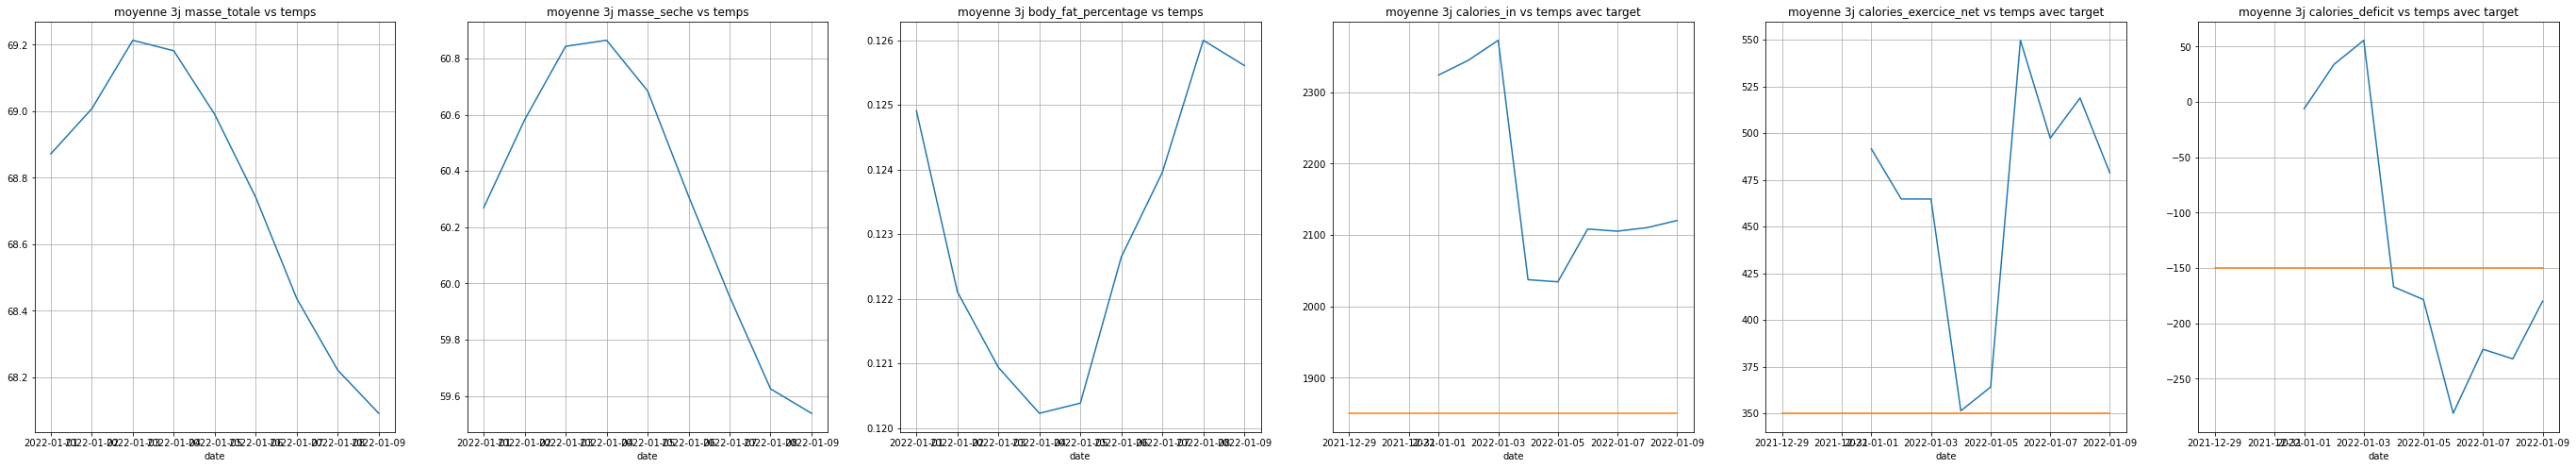

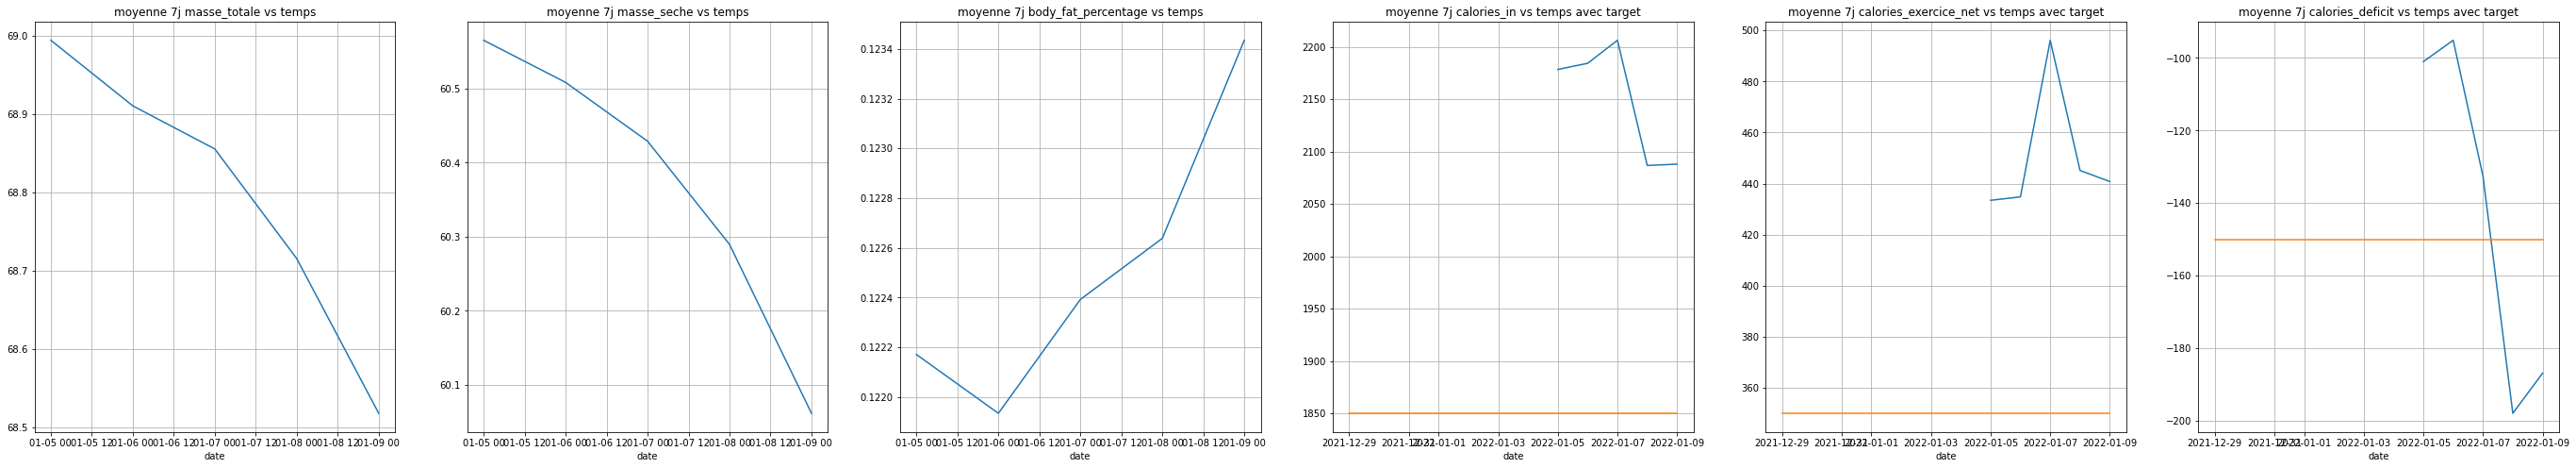

In [32]:
start_date = datetime.date(2021,12,29)
index_to_drop = [df.index < start_date]

df_last = df.drop(index = df.index[index_to_drop])

window_list = [3,7]

for w in window_list:
    wl.plot_moyennes_with_targets(df=df_last, list_of_moyennes=['masse_totale', 'masse_seche', 'body_fat_percentage', 'calories_in', 'calories_exercice_net', 'calories_deficit'], window=w)

C:\Users\benjamin.deporte\Anaconda3\envs\toy\lib\site-packages\pandas\core\indexing.py:1667: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value


,variation_masse_totale_moyenne,variation_masse_grasse_moyenne,variation_masse_seche_moyenne,calories_deficit_moyenne,calories_cardio_net_moyenne,calories_strength_net_moyenne
variation_masse_totale_moyenne,1.000000,-0.784870,0.972944,0.837234,0.378186,-0.185066
variation_masse_grasse_moyenne,-0.784870,1.000000,-0.906801,-0.606485,-0.221390,0.022895
variation_masse_seche_moyenne,0.972944,-0.906801,1.000000,0.795703,0.339827,-0.134437
calories_deficit_moyenne,0.837234,-0.606485,0.795703,1.000000,0.631134,-0.483100
calories_cardio_net_moyenne,0.378186,-0.221390,0.339827,0.631134,1.000000,-0.870623
calories_strength_net_moyenne,-0.185066,0.022895,-0.134437,-0.483100,-0.870623,1.000000


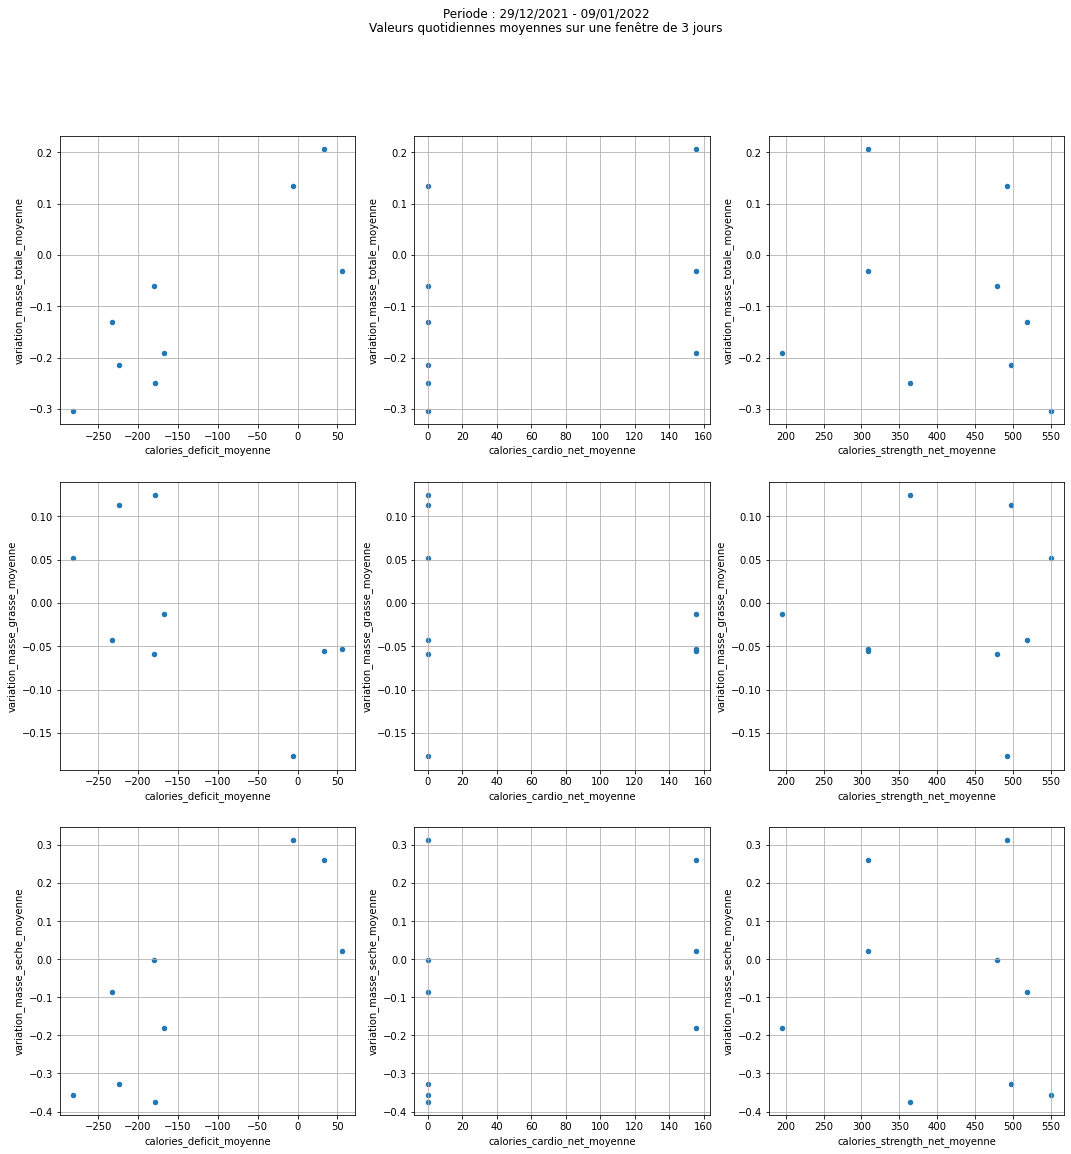

In [33]:
correlations_moyenne(df=df_last, window=3)

## Recherche de modèle...

In [34]:
def correlation_regression(df,
                           columns_names=['masse_totale', 'calories_deficit'],
                           window=7
                           ):
    """Utility function pour calculer et tracer une regression linéaire entre deux séries moyennées d'une dataframe.
    La première série est une série de type 'masse' sur laquelle on va moyenner les variations,
    La deuxième série est une série de type 'calories' sur laquelle on moyenne la valeur journalière.

    Args:
        df ([pd.Dataframe]): dataframe contenant les deux séries à traiter
        columns_names (list, optional): [les deux colonnes à traiter]. Defaults to ['masse_totale', 'calories_deficit'].
        window (int, optional): [la fenêtre sur laquelle on moyenne]. Defaults to 7.
        
    Returns:
        coeffs : pente
        intercept : ordonnée à l'origine
        score : coefficient de corrélation
        residus : numpy array des prédictions - ground truth
    """
    
    # rajouter des tests sur columns_names ici
    df_test = df[columns_names]
    
    # récupère la période sous forme de string
    name = get_periode(df_test)
    
    # calcule la moyenne des variations de la première série 'masse'
    c = columns_names[0]
    c0_moy = 'variation_' + c + '_moyenne'
    df_test.loc[:,c0_moy] = df_test[c].diff(1).rolling(window).mean().to_numpy()
        
    # calcule la moyenne des valeurs de la deuxième série 'calories'
    c = columns_names[1]
    c1_moy = c + '_moyenne'
    df_test.loc[:,c1_moy] = df_test[c].rolling(window).mean().shift(1).to_numpy()
        
    df_test = df_test[window:]
    
    # affiche data de corrélation
    display(df_test.corr())
    
    # régression linéaire
    x = df_test.loc[:,c1_moy].to_numpy().reshape(-1,1)
    y = df_test.loc[:,c0_moy].to_numpy()
    model_lr = LinearRegression()
    # print(x.shape)
    # print(y.shape)
    model_lr.fit(x,y)
    y_pred = model_lr.predict(x)
    c = columns_names[0]
    c0_moy_pred = 'variation_' + c + '_moyenne_pred'
    df_test.loc[:,c0_moy_pred] = y_pred
    coeffs, intercept = model_lr.coef_, model_lr.intercept_
    score = model_lr.score(x,y)
    residus = y_pred - y
    # print(y_pred)
    
    # trace
    fig,ax = plt.subplots(1, 1, figsize=(8,8))
    fig.suptitle('Periode : ' + name + f'\nValeurs quotidiennes moyennes sur une fenêtre de {window} jours')
    df_test.plot.scatter(c1_moy, c0_moy, ax=ax, grid=True)
    df_test.plot(c1_moy, c0_moy_pred, ax=ax, grid=True, color='red')
    plt.show()
    
    print(f'pente = {coeffs*100}/jour, {coeffs*30*100}/mois, pour 100 unités')
    print(f'score R_square = {score}')
    print(f'info : y=0 pour x={-intercept/coeffs}')
    
    return coeffs, intercept, score, residus

### Masse totale en fonction déficit calorique

In [35]:
# Variation masse totale vs deficit calories

# c,i,s,res = correlation_regression(df=df, window=1)

In [36]:
""" fig, ax = plt.subplots(1,1,figsize=(8,8))
ax.set_title('residus')
ax.grid(True)
ax = plt.hist(res) """

" fig, ax = plt.subplots(1,1,figsize=(8,8))\nax.set_title('residus')\nax.grid(True)\nax = plt.hist(res) "

C:\Users\benjamin.deporte\Anaconda3\envs\toy\lib\site-packages\pandas\core\indexing.py:1667: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value


,masse_totale,calories_deficit,variation_masse_totale_moyenne,calories_deficit_moyenne
masse_totale,1.000000,-0.487907,-0.863750,-0.908279
calories_deficit,-0.487907,1.000000,0.442640,0.483691
variation_masse_totale_moyenne,-0.863750,0.442640,1.000000,0.888202
calories_deficit_moyenne,-0.908279,0.483691,0.888202,1.000000


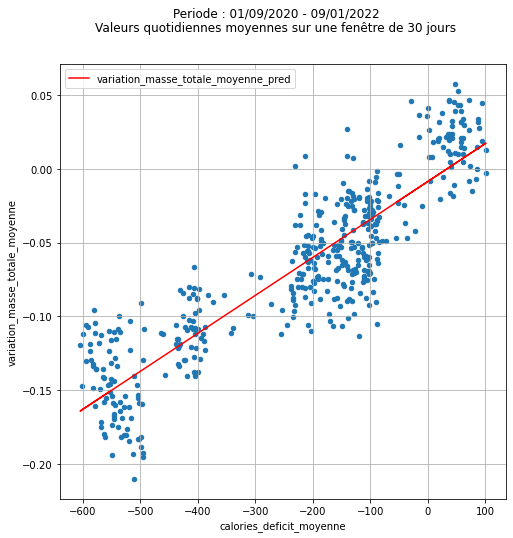

pente = [0.0257385]/jour, [0.77215505]/mois, pour 100 unités
score R_square = 0.7889024123242937
info : y=0 pour x=[33.43306036]


In [37]:
c,i,s,res = correlation_regression(df=df, window=30)

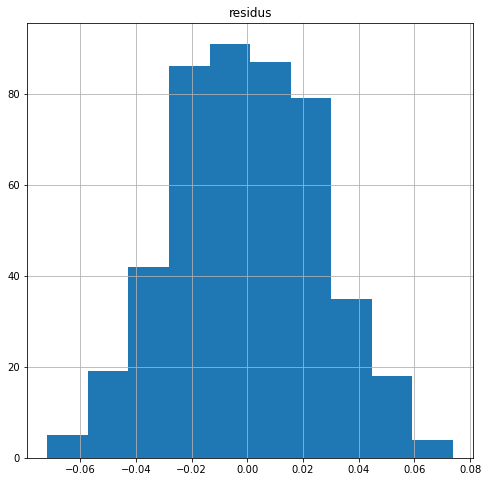

In [38]:
fig, ax = plt.subplots(1,1,figsize=(8,8))
ax.set_title('residus')
ax.grid(True)
ax = plt.hist(res)

In [39]:
# c,i,s, res = correlation_regression(df=df, window=60)

In [40]:
""" fig, ax = plt.subplots(1,1,figsize=(8,8))
ax.set_title('residus')
ax.grid(True)
ax = plt.hist(res) """

" fig, ax = plt.subplots(1,1,figsize=(8,8))\nax.set_title('residus')\nax.grid(True)\nax = plt.hist(res) "

### Masse grasse en fonction déficit calorique

In [41]:
# c,i,s,res = correlation_regression(df=df, columns_names=['masse_grasse', 'calories_deficit'], window=1)

In [42]:
""" fig, ax = plt.subplots(1,1,figsize=(8,8))
ax.set_title('residus')
ax.grid(True)
ax = plt.hist(res) """

" fig, ax = plt.subplots(1,1,figsize=(8,8))\nax.set_title('residus')\nax.grid(True)\nax = plt.hist(res) "

In [43]:
# c,i,s,res = correlation_regression(df=df, columns_names=['masse_grasse', 'calories_deficit'], window=15)

In [44]:
""" fig, ax = plt.subplots(1,1,figsize=(8,8))
ax.set_title('residus')
ax.grid(True)
ax = plt.hist(res) """

" fig, ax = plt.subplots(1,1,figsize=(8,8))\nax.set_title('residus')\nax.grid(True)\nax = plt.hist(res) "

C:\Users\benjamin.deporte\Anaconda3\envs\toy\lib\site-packages\pandas\core\indexing.py:1667: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value


,masse_grasse,calories_deficit,variation_masse_grasse_moyenne,calories_deficit_moyenne
masse_grasse,1.000000,-0.485388,-0.805214,-0.906889
calories_deficit,-0.485388,1.000000,0.430403,0.483691
variation_masse_grasse_moyenne,-0.805214,0.430403,1.000000,0.828521
calories_deficit_moyenne,-0.906889,0.483691,0.828521,1.000000


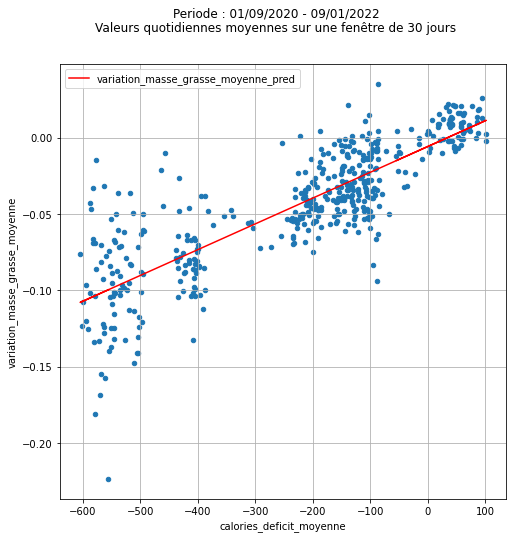

pente = [0.01690776]/jour, [0.50723284]/mois, pour 100 unités
score R_square = 0.6864474928055632
info : y=0 pour x=[34.58035296]


In [45]:
c,i,s,res = correlation_regression(df=df, columns_names=['masse_grasse', 'calories_deficit'], window=30)

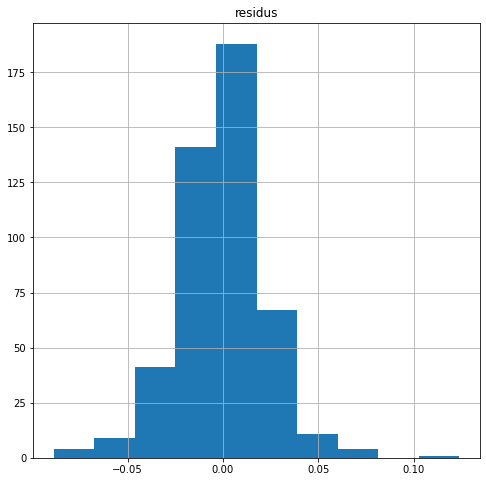

In [46]:
fig, ax = plt.subplots(1,1,figsize=(8,8))
ax.set_title('residus')
ax.grid(True)
ax = plt.hist(res)

In [47]:
# c,i,s,res = correlation_regression(df=df, columns_names=['masse_grasse', 'calories_deficit'], window=60)

In [48]:
""" fig, ax = plt.subplots(1,1,figsize=(8,8))
ax.set_title('residus')
ax.grid(True)
ax = plt.hist(res) """

" fig, ax = plt.subplots(1,1,figsize=(8,8))\nax.set_title('residus')\nax.grid(True)\nax = plt.hist(res) "

In [49]:
# c,i,s,res = correlation_regression(df=df, columns_names=['masse_grasse', 'calories_cardio'], window=60)

### Masse sèche en fonction du déficit calorique

C:\Users\benjamin.deporte\Anaconda3\envs\toy\lib\site-packages\pandas\core\indexing.py:1667: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value


,masse_seche,calories_deficit,variation_masse_seche_moyenne,calories_deficit_moyenne
masse_seche,1.000000,-0.483750,-0.368978,-0.894545
calories_deficit,-0.483750,1.000000,0.231986,0.483691
variation_masse_seche_moyenne,-0.368978,0.231986,1.000000,0.506629
calories_deficit_moyenne,-0.894545,0.483691,0.506629,1.000000


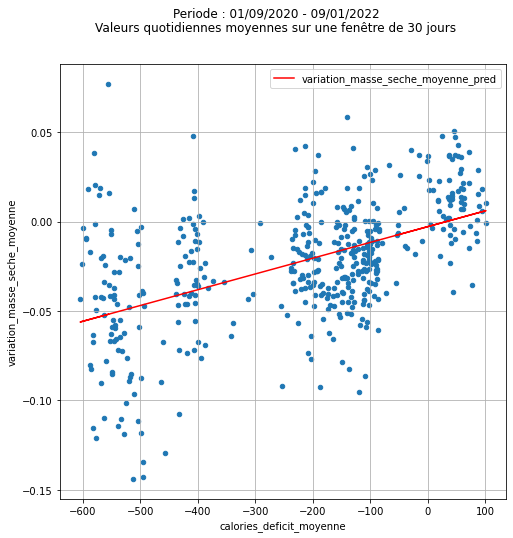

pente = [0.00883074]/jour, [0.26492222]/mois, pour 100 unités
score R_square = 0.2566728636897664
info : y=0 pour x=[31.23639869]


In [50]:
c,i,s,res = correlation_regression(df=df, columns_names=['masse_seche', 'calories_deficit'], window=30)

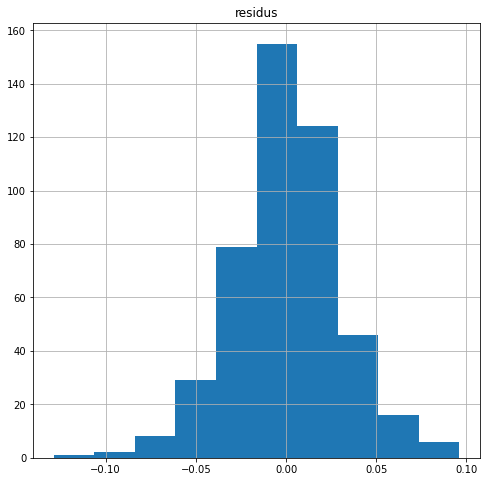

In [51]:
fig, ax = plt.subplots(1,1,figsize=(8,8))
ax.set_title('residus')
ax.grid(True)
ax = plt.hist(res)

### Masse grasse en fonction du calories strength

C:\Users\benjamin.deporte\Anaconda3\envs\toy\lib\site-packages\pandas\core\indexing.py:1667: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value


,masse_grasse,calories_strength,variation_masse_grasse_moyenne,calories_strength_moyenne
masse_grasse,1.000000,-0.347483,-0.805214,-0.747544
calories_strength,-0.347483,1.000000,0.333547,0.431073
variation_masse_grasse_moyenne,-0.805214,0.333547,1.000000,0.734991
calories_strength_moyenne,-0.747544,0.431073,0.734991,1.000000


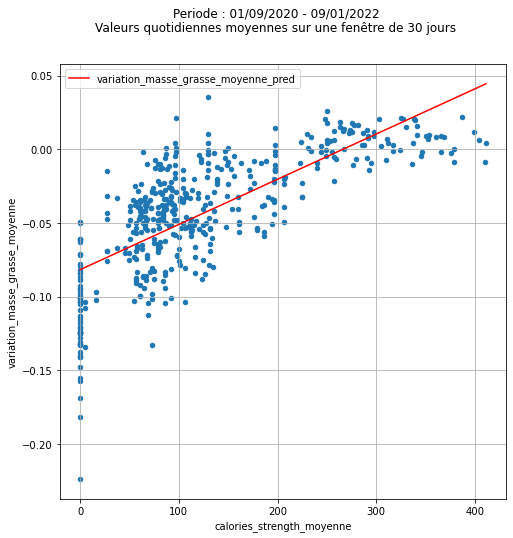

pente = [0.03067311]/jour, [0.92019326]/mois, pour 100 unités
score R_square = 0.5402113960182975
info : y=0 pour x=[266.18688123]


In [52]:
c,i,s,res = correlation_regression(df=df, columns_names=['masse_grasse', 'calories_strength'], window=30)

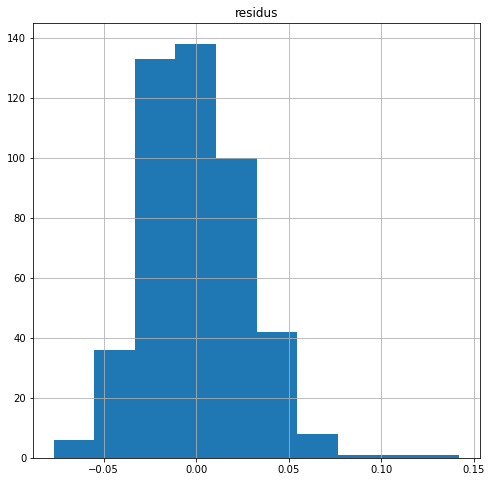

In [53]:
fig, ax = plt.subplots(1,1,figsize=(8,8))
ax.set_title('residus')
ax.grid(True)
ax = plt.hist(res)

### Masse sèche en fonction du calories strength

In [54]:
# c,i,s,res = correlation_regression(df=df, columns_names=['masse_seche', 'calories_strength'], window=1)

In [55]:
""" fig, ax = plt.subplots(1,1,figsize=(8,8))
ax.set_title('residus')
ax.grid(True)
ax = plt.hist(res) """

" fig, ax = plt.subplots(1,1,figsize=(8,8))\nax.set_title('residus')\nax.grid(True)\nax = plt.hist(res) "

In [56]:
# c,i,s,res = correlation_regression(df=df, columns_names=['masse_seche', 'calories_strength'], window=7)

In [57]:
""" fig, ax = plt.subplots(1,1,figsize=(8,8))
ax.set_title('residus')
ax.grid(True)
ax = plt.hist(res) """

" fig, ax = plt.subplots(1,1,figsize=(8,8))\nax.set_title('residus')\nax.grid(True)\nax = plt.hist(res) "

In [58]:
# c,i,s,res = correlation_regression(df=df, columns_names=['masse_seche', 'calories_strength'], window=15)

In [59]:
""" fig, ax = plt.subplots(1,1,figsize=(8,8))
ax.set_title('residus')
ax.grid(True)
ax = plt.hist(res) """

" fig, ax = plt.subplots(1,1,figsize=(8,8))\nax.set_title('residus')\nax.grid(True)\nax = plt.hist(res) "

C:\Users\benjamin.deporte\Anaconda3\envs\toy\lib\site-packages\pandas\core\indexing.py:1667: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value


,masse_seche,calories_strength,variation_masse_seche_moyenne,calories_strength_moyenne
masse_seche,1.000000,-0.350636,-0.368978,-0.725434
calories_strength,-0.350636,1.000000,0.208498,0.431073
variation_masse_seche_moyenne,-0.368978,0.208498,1.000000,0.531047
calories_strength_moyenne,-0.725434,0.431073,0.531047,1.000000


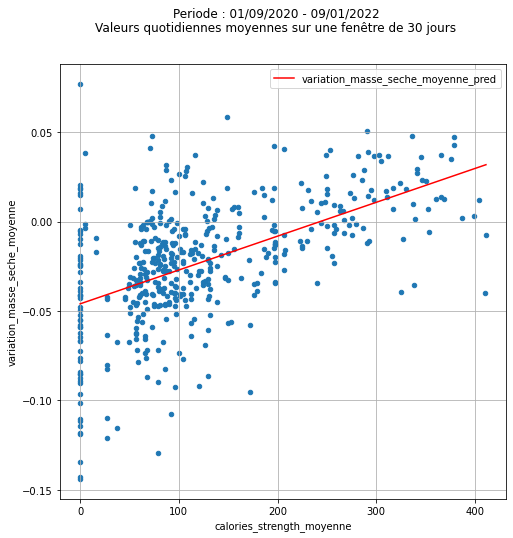

pente = [0.01892926]/jour, [0.56787787]/mois, pour 100 unités
score R_square = 0.2820110465981226
info : y=0 pour x=[242.81582886]


In [60]:
c,i,s,res = correlation_regression(df=df, columns_names=['masse_seche', 'calories_strength'], window=30)

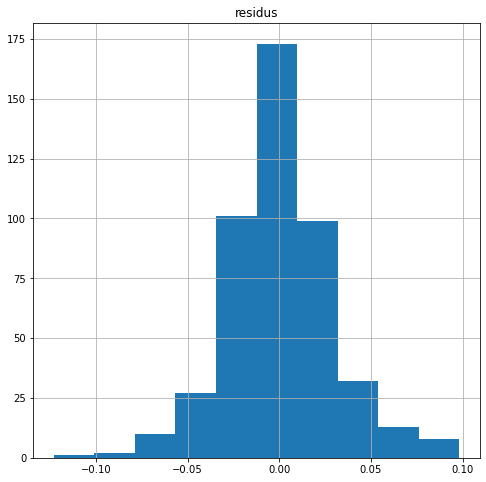

In [61]:
fig, ax = plt.subplots(1,1,figsize=(8,8))
ax.set_title('residus')
ax.grid(True)
ax = plt.hist(res)

In [62]:
# c,i,s,res = correlation_regression(df=df, columns_names=['masse_seche', 'calories_strength'], window=60)

In [63]:
""" fig, ax = plt.subplots(1,1,figsize=(8,8))
ax.set_title('residus')
ax.grid(True)
ax = plt.hist(res) """

" fig, ax = plt.subplots(1,1,figsize=(8,8))\nax.set_title('residus')\nax.grid(True)\nax = plt.hist(res) "

## Modèle Sèche

In [64]:
# w = 7

# c,i,s,res = correlation_regression(df=df_seche, window=w)

# c,i,s,res = correlation_regression(df=df_seche, columns_names=['masse_grasse', 'calories_deficit'], window=w)

# c,i,s,res = correlation_regression(df=df_seche, columns_names=['masse_seche', 'calories_deficit'], window=w)

## Modèle "bulk"

In [65]:
# w = 7

# c,i,s,res = correlation_regression(df=df_bulk, window=w)

# c,i,s,res = correlation_regression(df=df_bulk, columns_names=['masse_grasse', 'calories_deficit'], window=w)

# c,i,s,res = correlation_regression(df=df_bulk, columns_names=['masse_seche', 'calories_deficit'], window=w)

# c,i,s,res = correlation_regression(df=df_bulk, columns_names=['masse_seche', 'calories_strength'], window=w)

# Recherche régression linéaire à deux variables

masse_totale et masse_grasse (quand on les moyenne) corrèlent bien avec calories_deficit, et dans une moindre mesure calories_strength

On va tenter la régression bi-variable

In [66]:
def correlation_regression_bi(df,
                           columns_names=['masse_totale', 'calories_deficit', 'calories_strength'],
                           window=7
                           ):
    """Utility function pour calculer et tracer une regression linéaire entre une série moyennée d'une dataframe,
    et deux séries variables.
    La première série est une série de type 'masse' sur laquelle on va moyenner les variations,
    Les deux séries variables sont des séries de type 'calories' sur laquelle on moyenne la valeur journalière.

    Args:
        df ([pd.Dataframe]): dataframe contenant les deux séries à traiter
        columns_names (list, optional): [les trois colonnes à traiter]. Defaults to ['masse_totale', 'calories_deficit', 'calories_strength].
        window (int, optional): [la fenêtre sur laquelle on moyenne]. Defaults to 7.
        
    Returns:
        coeffs : pente
        intercept : ordonnée à l'origine
        score : coefficient de corrélation
        residus : numpy array des prédictions - ground truth
    """
    
    # rajouter des tests sur columns_names ici
    df_test = df[columns_names]
    
    # récupère la période sous forme de string
    name = get_periode(df_test)
    
    # calcule la moyenne des variations de la première série 'masse'
    c = columns_names[0]
    c0_moy = 'variation_' + c + '_moyenne'
    df_test.loc[:,c0_moy] = df_test[c].diff(1).rolling(window).mean().to_numpy()
        
    # calcule la moyenne des valeurs des deux séries 'calories'
    c = columns_names[1]
    c1_moy = c + '_moyenne'
    df_test.loc[:,c1_moy] = df_test[c].rolling(window).mean().shift(1).to_numpy()
    c = columns_names[2]
    c2_moy = c + '_moyenne'
    df_test.loc[:,c2_moy] = df_test[c].rolling(window).mean().shift(1).to_numpy()
        
    df_test = df_test[window:]
    
    # affiche data de corrélation
    display(df_test.corr())
    
    # régression linéaire
    x = df_test.loc[:,[c1_moy, c2_moy]].to_numpy().reshape(-1,2)
    y = df_test.loc[:,c0_moy].to_numpy()
    model_lr = LinearRegression()
    print(x.shape)
    print(y.shape)
    model_lr.fit(x,y)
    y_pred = model_lr.predict(x)
    c = columns_names[0]
    c0_moy_pred = 'variation_' + c + '_moyenne_pred'
    df_test.loc[:,c0_moy_pred] = y_pred
    coeffs, intercept = model_lr.coef_, model_lr.intercept_
    score = model_lr.score(x,y)
    residus = y_pred - y
    # print(y_pred)
    
    # trace
    # fig,ax = plt.subplots(1, 1, figsize=(8,8))
    # fig.suptitle('Periode : ' + name + f'\nValeurs quotidiennes moyennes sur une fenêtre de {window} jours')
    # df_test.plot.scatter(c1_moy, c0_moy, ax=ax, grid=True)
    # df_test.plot(c1_moy, c0_moy_pred, ax=ax, grid=True, color='red')
    # plt.show()
    
    # print(f'pente = {coeffs*100}/jour, {coeffs*30*100}/mois, pour 100 unités')
    print(f'score R_square = {score}')
    # print(f'info : y=0 pour x={-intercept/coeffs}')
    
    return coeffs, intercept, score, residus, model_lr

In [67]:
c,i,s,res,model_mt = correlation_regression_bi(df, window=60)

C:\Users\benjamin.deporte\Anaconda3\envs\toy\lib\site-packages\pandas\core\indexing.py:1667: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value


,masse_totale,calories_deficit,calories_strength,variation_masse_totale_moyenne,calories_deficit_moyenne,calories_strength_moyenne
masse_totale,1.000000,-0.462474,-0.321038,-0.904509,-0.927133,-0.758430
calories_deficit,-0.462474,1.000000,-0.108208,0.434137,0.449157,0.392646
calories_strength,-0.321038,-0.108208,1.000000,0.380510,0.343448,0.421325
variation_masse_totale_moyenne,-0.904509,0.434137,0.380510,1.000000,0.945306,0.898689
calories_deficit_moyenne,-0.927133,0.449157,0.343448,0.945306,1.000000,0.815414
calories_strength_moyenne,-0.758430,0.392646,0.421325,0.898689,0.815414,1.000000


(436, 2)
(436,)
score R_square = 0.9423988085176431


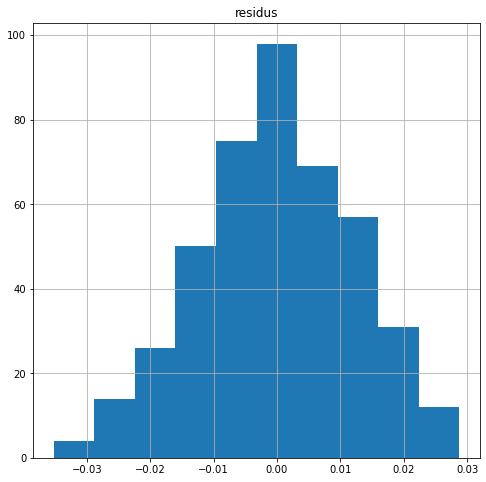

In [68]:
fig, ax = plt.subplots(1,1,figsize=(8,8))
ax.set_title('residus')
ax.grid(True)
ax = plt.hist(res)

In [69]:
c,i,s,res,model_mg = correlation_regression_bi(df, 
                                      columns_names=['masse_grasse', 'calories_deficit', 'calories_strength'],
                                      window=60)

C:\Users\benjamin.deporte\Anaconda3\envs\toy\lib\site-packages\pandas\core\indexing.py:1667: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value


,masse_grasse,calories_deficit,calories_strength,variation_masse_grasse_moyenne,calories_deficit_moyenne,calories_strength_moyenne
masse_grasse,1.000000,-0.459312,-0.317386,-0.893891,-0.927396,-0.762806
calories_deficit,-0.459312,1.000000,-0.108208,0.426636,0.449157,0.392646
calories_strength,-0.317386,-0.108208,1.000000,0.366293,0.343448,0.421325
variation_masse_grasse_moyenne,-0.893891,0.426636,0.366293,1.000000,0.923265,0.849449
calories_deficit_moyenne,-0.927396,0.449157,0.343448,0.923265,1.000000,0.815414
calories_strength_moyenne,-0.762806,0.392646,0.421325,0.849449,0.815414,1.000000


(436, 2)
(436,)
score R_square = 0.8802693541569296


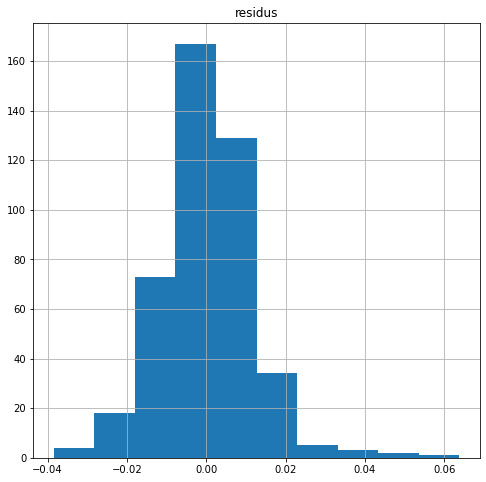

In [70]:
fig, ax = plt.subplots(1,1,figsize=(8,8))
ax.set_title('residus')
ax.grid(True)
ax = plt.hist(res)

### Les résidus sont globalement gaussiens - la régression linéaire est suffisante

# Prédictions...

In [78]:
x = np.array([-150.0, 350.0]).reshape(-1,2)

delta_mt = model_mt.predict(x)[0]*30
delta_mg = model_mg.predict(x)[0]*30

mt = 68.0
mg = 8.5
delta_bf = (mg + delta_mg)/(mt + delta_mt) - mg/mt

print(f'variation de masse totale mensuelle : {delta_mt}')
print(f'variation de masse grasse mensuelle : {delta_mg}')
print(f'variation de masse sèche mensuelle : {delta_mt - delta_mg}')
print(f'variation body fat mensuelle (%): {delta_bf * 100}')

variation de masse totale mensuelle : -0.024256589579866594
variation de masse grasse mensuelle : -0.22027294429471156
variation de masse sèche mensuelle : 0.19601635471484496
variation body fat mensuelle (%): -0.3195858694557907


### Tracés

In [96]:
nx = 61
ny = 41

In [97]:
x1 = np.linspace(-500.0,100.0,num=nx)
x2 = np.linspace(0.0,400.0,num=ny)

In [98]:
i = 0
x = np.zeros(shape=nx*ny)
y = np.zeros(shape=nx*ny)
var_mt = np.zeros(shape=nx*ny)
var_mg = np.zeros(shape=nx*ny)
var_ms = np.zeros(shape=nx*ny)

for xx1 in list(x1):
    for xx2 in list(x2):
        xx = np.array([xx1,xx2]).reshape(-1,2)
        x[i] = xx1
        y[i] = xx2
        var_mt[i] = model_mt.predict(xx)[0]*30
        var_mg[i] = model_mg.predict(xx)[0]*30
        var_ms[i] = var_mt[i] - var_mg[i]
        i = i+1
        

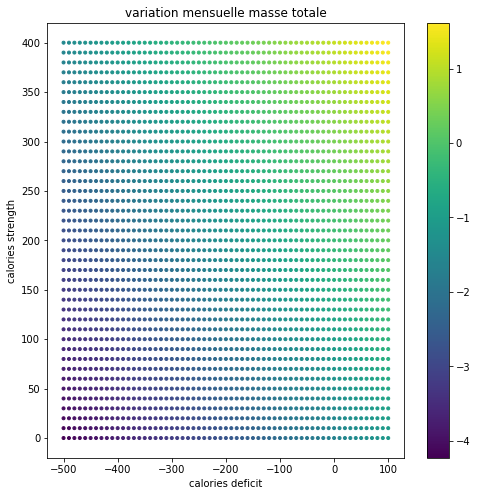

In [101]:
fig, ax = plt.subplots(1,1,figsize=(8,8))
ax.set_title('variation mensuelle masse totale')
ax.set_xlabel('calories deficit')
ax.set_ylabel('calories strength')

plt.scatter(x,y, c = var_mt, cmap='viridis', marker='.')
plt.colorbar()
plt.show()

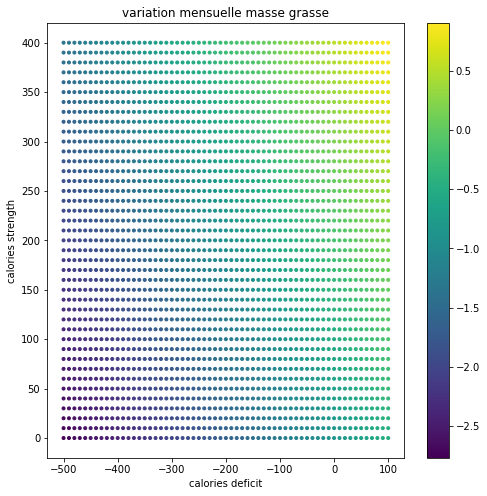

In [102]:
fig, ax = plt.subplots(1,1,figsize=(8,8))
ax.set_title('variation mensuelle masse grasse')
ax.set_xlabel('calories deficit')
ax.set_ylabel('calories strength')

plt.scatter(x,y, c = var_mg, cmap='viridis', marker='.')
plt.colorbar()
plt.show()

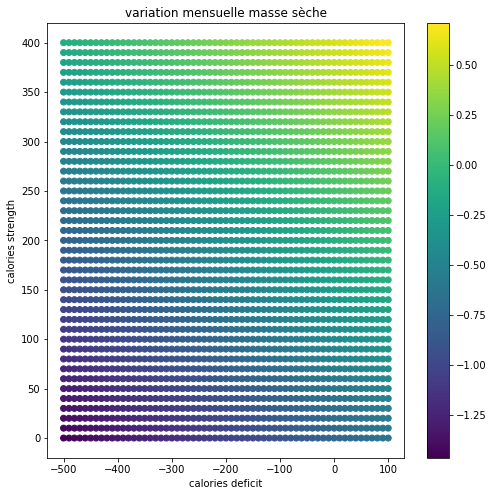

In [105]:
fig, ax = plt.subplots(1,1,figsize=(8,8))
ax.set_title('variation mensuelle masse sèche')
ax.set_xlabel('calories deficit')
ax.set_ylabel('calories strength')

plt.scatter(x,y, c = var_ms, cmap='viridis', marker='o')
plt.colorbar()
plt.show()